# 라이브러리 준비

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
from scipy.spatial import distance 

from statsmodels.formula.api import ols
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
import math


# 그래프 한글, 마이너스 깨짐 방지

font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
plt.rcParams['axes.unicode_minus'] = False
rc('font', family=font_name)

# 데이터 불러오기 이었는데 다시 통합 및 저장

In [763]:
month_df = pd.read_csv('./pre_data/월별_통합.csv', encoding='utf8')
month_df.columns

Index(['Unnamed: 0', 'date', '닭고기가격', '병아리(원/수)', '일별_평균기온', '일별_최저기온',
       '일별_최고기온', '13도미만_평균기온', '13도미만_최저기온', '13도미만_최고기온', '25도이상_평균기온',
       '25도이상_최저기온', '25도이상_최고기온', 'hot_day', 'cold_day', 'import amount',
       'feedprice', 'Dubai', 'Brent', 'WTI', 'oil_avg', 'count', '도축'],
      dtype='object')

In [764]:
month_df = month_df.drop(columns=['Unnamed: 0', '일별_평균기온', '일별_최저기온','일별_최고기온', '13도미만_평균기온','13도미만_최저기온','13도미만_최고기온',
                                  '25도이상_평균기온','25도이상_최저기온', '25도이상_최고기온', 'cold_day', 'Dubai', 'Brent', 'WTI','count'])
month_df.fillna('0', inplace=True)
month_df['date'] = pd.to_datetime(month_df['date'])
month_df

,date,닭고기가격,병아리(원/수),hot_day,import amount,feedprice,oil_avg,도축
0,2012-01-31,3202,250,0,8754,533,107.066111,58873
1,2012-02-29,3668,420,0,10098,529,112.537302,55879
2,2012-03-31,4169,500,0,10836,527,117.745606,58750
3,2012-04-30,3399,332,0,13412,526,113.723667,60940
4,2012-05-31,3255,200,0,14519,526,104.184710,73505
...,...,...,...,...,...,...,...,...
115,2021-08-31,3505,312,3.0,9360,492,69.247955,89892
116,2021-09-30,3074,408,0,9009,503,72.975152,81026
117,2021-10-31,3913,447,0,12005,508,82.193333,81228
118,2021-11-30,2985,315,0,10025,520,79.858712,86819


In [765]:
cow_df = pd.read_csv('./pre_data/월별_소_소비자가격.csv', encoding='utf8')
month_df['cow'] = cow_df['소_소비자가_int']
pig_df = pd.read_csv('./pre_data/월별_돼지_소비자가격.csv', encoding='utf8')
month_df['pig'] = pig_df['돼지_소비자가_int']
month_df

,date,닭고기가격,병아리(원/수),hot_day,import amount,feedprice,oil_avg,도축,cow,pig
0,2012-01-31,3202,250,0,8754,533,107.066111,58873,59981.578947,18465.263158
1,2012-02-29,3668,420,0,10098,529,112.537302,55879,56019.047619,16634.761905
2,2012-03-31,4169,500,0,10836,527,117.745606,58750,50899.047619,16317.619048
3,2012-04-30,3399,332,0,13412,526,113.723667,60940,53879.700000,15882.100000
4,2012-05-31,3255,200,0,14519,526,104.184710,73505,55403.047619,16798.619048
...,...,...,...,...,...,...,...,...,...,...
115,2021-08-31,3505,312,3.0,9360,492,69.247955,89892,99247.863636,26078.045455
116,2021-09-30,3074,408,0,9009,503,72.975152,81026,103039.842105,26346.052632
117,2021-10-31,3913,447,0,12005,508,82.193333,81228,110791.666667,25977.333333
118,2021-11-30,2985,315,0,10025,520,79.858712,86819,107207.636364,25217.727273


In [766]:
kor_ir = pd.read_csv('./data/한국_기준금리.csv', encoding='cp949')
kor_ir = kor_ir.loc[::-1]
kor_ir.reset_index(drop=True, inplace=True)
# 데이터 형 변환
kor_ir['date'] = pd.to_datetime(kor_ir['date'])

# 각 날짜를 월말로 바꿈
kor_ir['date'] = kor_ir['date'] + pd.offsets.MonthEnd(0) 
kor_ir

# 2022년 데이터 제거
drop_2022 = kor_ir[kor_ir['date'] >= '2022-01-01' ].index
kor_ir = kor_ir.drop(drop_2022)
kor_ir

# 병합
month_df = pd.merge(month_df, kor_ir, how='outer', on='date')

# null 값 앞에 걸로
month_df.fillna(method='ffill', inplace=True)
month_df.fillna('3.25', inplace=True)

month_df

,date,닭고기가격,병아리(원/수),hot_day,import amount,feedprice,oil_avg,도축,cow,pig,한국기준금리
0,2012-01-31,3202,250,0,8754,533,107.066111,58873,59981.578947,18465.263158,3.25
1,2012-02-29,3668,420,0,10098,529,112.537302,55879,56019.047619,16634.761905,3.25
2,2012-03-31,4169,500,0,10836,527,117.745606,58750,50899.047619,16317.619048,3.25
3,2012-04-30,3399,332,0,13412,526,113.723667,60940,53879.700000,15882.100000,3.25
4,2012-05-31,3255,200,0,14519,526,104.184710,73505,55403.047619,16798.619048,3.25
...,...,...,...,...,...,...,...,...,...,...,...
115,2021-08-31,3505,312,3.0,9360,492,69.247955,89892,99247.863636,26078.045455,0.75
116,2021-09-30,3074,408,0,9009,503,72.975152,81026,103039.842105,26346.052632,0.75
117,2021-10-31,3913,447,0,12005,508,82.193333,81228,110791.666667,25977.333333,0.75
118,2021-11-30,2985,315,0,10025,520,79.858712,86819,107207.636364,25217.727273,1.0


In [770]:
usa_ir = pd.read_csv('./pre_data/미금리전처리.csv', encoding='cp949')
month_df['미국기준금리'] = usa_ir['미국기준금리']
month_df

,date,닭고기가격,병아리(원/수),hot_day,import amount,feedprice,oil_avg,도축,cow,pig,한국기준금리,미국기준금리
0,2012-01-31,3202,250,0,8754,533,107.066111,58873,59981.578947,18465.263158,3.25,0.25
1,2012-02-29,3668,420,0,10098,529,112.537302,55879,56019.047619,16634.761905,3.25,0.25
2,2012-03-31,4169,500,0,10836,527,117.745606,58750,50899.047619,16317.619048,3.25,0.25
3,2012-04-30,3399,332,0,13412,526,113.723667,60940,53879.700000,15882.100000,3.25,0.25
4,2012-05-31,3255,200,0,14519,526,104.184710,73505,55403.047619,16798.619048,3.25,0.25
...,...,...,...,...,...,...,...,...,...,...,...,...
115,2021-08-31,3505,312,3.0,9360,492,69.247955,89892,99247.863636,26078.045455,0.75,0.25
116,2021-09-30,3074,408,0,9009,503,72.975152,81026,103039.842105,26346.052632,0.75,0.25
117,2021-10-31,3913,447,0,12005,508,82.193333,81228,110791.666667,25977.333333,0.75,0.25
118,2021-11-30,2985,315,0,10025,520,79.858712,86819,107207.636364,25217.727273,1.0,0.25


In [771]:
month_df.columns = ['date', 'price', 'chick', 'hot_day','import', 'feedprice', 'oil', 'butchery','cow','pig','kor_ir','usa_ir']
month_df

,date,price,chick,hot_day,import,feedprice,oil,butchery,cow,pig,kor_ir,usa_ir
0,2012-01-31,3202,250,0,8754,533,107.066111,58873,59981.578947,18465.263158,3.25,0.25
1,2012-02-29,3668,420,0,10098,529,112.537302,55879,56019.047619,16634.761905,3.25,0.25
2,2012-03-31,4169,500,0,10836,527,117.745606,58750,50899.047619,16317.619048,3.25,0.25
3,2012-04-30,3399,332,0,13412,526,113.723667,60940,53879.700000,15882.100000,3.25,0.25
4,2012-05-31,3255,200,0,14519,526,104.184710,73505,55403.047619,16798.619048,3.25,0.25
...,...,...,...,...,...,...,...,...,...,...,...,...
115,2021-08-31,3505,312,3.0,9360,492,69.247955,89892,99247.863636,26078.045455,0.75,0.25
116,2021-09-30,3074,408,0,9009,503,72.975152,81026,103039.842105,26346.052632,0.75,0.25
117,2021-10-31,3913,447,0,12005,508,82.193333,81228,110791.666667,25977.333333,0.75,0.25
118,2021-11-30,2985,315,0,10025,520,79.858712,86819,107207.636364,25217.727273,1.0,0.25


In [775]:
month_df['kor_ir'] = pd.to_numeric(month_df['kor_ir'])
month_df['hot_day'] = pd.to_numeric(month_df['hot_day'])
month_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 120 entries, 0 to 119
Data columns (total 12 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   date       120 non-null    datetime64[ns]
 1   price      120 non-null    int64         
 2   chick      120 non-null    int64         
 3   hot_day    120 non-null    float64       
 4   import     120 non-null    int64         
 5   feedprice  120 non-null    int64         
 6   oil        120 non-null    float64       
 7   butchery   120 non-null    int64         
 8   cow        120 non-null    float64       
 9   pig        120 non-null    float64       
 10  kor_ir     120 non-null    float64       
 11  usa_ir     120 non-null    float64       
dtypes: datetime64[ns](1), float64(6), int64(5)
memory usage: 12.2 KB


In [776]:
# 저장
month_df.to_csv('./pre_data/월별_통합2.csv', sep=',', encoding='cp949', index=False)

# 진짜 불러오기

In [3]:
month_df = pd.read_csv('./pre_data/월별_통합2.csv', encoding='cp949')
month_df

,date,price,chick,hot_day,import,feedprice,oil,butchery,cow,pig,kor_ir,usa_ir
0,2012-01-31,3202,250,0.0,8754,533,107.066111,58873,59981.578947,18465.263158,3.25,0.25
1,2012-02-29,3668,420,0.0,10098,529,112.537302,55879,56019.047619,16634.761905,3.25,0.25
2,2012-03-31,4169,500,0.0,10836,527,117.745606,58750,50899.047619,16317.619048,3.25,0.25
3,2012-04-30,3399,332,0.0,13412,526,113.723667,60940,53879.700000,15882.100000,3.25,0.25
4,2012-05-31,3255,200,0.0,14519,526,104.184710,73505,55403.047619,16798.619048,3.25,0.25
...,...,...,...,...,...,...,...,...,...,...,...,...
115,2021-08-31,3505,312,3.0,9360,492,69.247955,89892,99247.863636,26078.045455,0.75,0.25
116,2021-09-30,3074,408,0.0,9009,503,72.975152,81026,103039.842105,26346.052632,0.75,0.25
117,2021-10-31,3913,447,0.0,12005,508,82.193333,81228,110791.666667,25977.333333,0.75,0.25
118,2021-11-30,2985,315,0.0,10025,520,79.858712,86819,107207.636364,25217.727273,1.00,0.25


In [4]:
daily_df =pd.read_csv('./pre_data/일별_통합_모델링용[ai유무추가].csv', encoding='cp949')
daily_df.drop(columns=["Unnamed: 0"], inplace=True)
daily_df = daily_df.loc[::-1]
daily_df.columns = ['date', 'price', 'chick','oil','cow','pig','usa_ir','kor_ir','ai']
# daily_df = daily_df[daily_df['date'] >='2015-01-01']
# daily_df.drop(columns=['ai'], inplace=True)
daily_df.reset_index(drop=True, inplace=True)
daily_df

,date,price,chick,oil,cow,pig,usa_ir,kor_ir,ai
0,2012-01-02,3118,300,105.000000,61140,20320,0.75,3.25,0
1,2012-01-03,3118,300,107.000000,61030,20330,0.75,3.25,0
2,2012-01-04,3118,300,108.470000,61700,20300,0.75,3.25,0
3,2012-01-05,3118,200,108.260000,58870,19830,0.75,3.25,0
4,2012-01-06,3166,200,108.180000,58380,19570,0.75,3.25,0
...,...,...,...,...,...,...,...,...,...
2991,2021-12-27,3743,400,76.530000,109225,26993,0.25,1.00,0
2992,2021-12-28,3895,400,77.130000,110865,26936,0.25,1.00,0
2993,2021-12-29,3895,400,77.566667,112019,26891,0.25,1.00,0
2994,2021-12-30,4047,400,77.850000,111396,25411,0.25,1.00,1


In [5]:
oil_df = pd.read_csv('./pre_data/일별_원유가격.csv', encoding='utf8')
oil_df.drop(columns=['Unnamed: 0', 'Brent','WTI','oil_avg'], inplace=True)
daily_df = pd.merge(daily_df, oil_df, how='outer', on='date')
daily_df.head()

,date,price,chick,oil,cow,pig,usa_ir,kor_ir,ai,Dubai
0,2012-01-02,3118.0,300.0,105.00,61140.0,20320.0,0.75,3.25,0.0,NaN
1,2012-01-03,3118.0,300.0,107.00,61030.0,20330.0,0.75,3.25,0.0,105.91
2,2012-01-04,3118.0,300.0,108.47,61700.0,20300.0,0.75,3.25,0.0,108.49
3,2012-01-05,3118.0,200.0,108.26,58870.0,19830.0,0.75,3.25,0.0,110.23
4,2012-01-06,3166.0,200.0,108.18,58380.0,19570.0,0.75,3.25,0.0,109.92


In [6]:
daily_df['Dubai'].fillna(method='ffill', inplace=True)
daily_df['oil'] = daily_df['Dubai']
daily_df.drop(columns=['Dubai'], inplace=True)

daily_df.tail(20)

,date,price,chick,oil,cow,pig,usa_ir,kor_ir,ai
3077,2020-01-24,NaN,NaN,62.23,NaN,NaN,NaN,NaN,NaN
3078,2020-01-27,NaN,NaN,60.40,NaN,NaN,NaN,NaN,NaN
3079,2020-04-15,NaN,NaN,19.68,NaN,NaN,NaN,NaN,NaN
3080,2020-04-30,NaN,NaN,20.73,NaN,NaN,NaN,NaN,NaN
3081,2020-05-05,NaN,NaN,26.00,NaN,NaN,NaN,NaN,NaN
3082,2020-09-30,NaN,NaN,40.36,NaN,NaN,NaN,NaN,NaN
3083,2020-10-01,NaN,NaN,41.12,NaN,NaN,NaN,NaN,NaN
3084,2020-10-02,NaN,NaN,38.62,NaN,NaN,NaN,NaN,NaN
3085,2020-10-09,NaN,NaN,42.06,NaN,NaN,NaN,NaN,NaN
3086,2021-02-11,NaN,NaN,60.54,NaN,NaN,NaN,NaN,NaN


In [7]:
daily_df.dropna(axis=0, inplace=True)
daily_df

,date,price,chick,oil,cow,pig,usa_ir,kor_ir,ai
1,2012-01-03,3118.0,300.0,105.91,61030.0,20330.0,0.75,3.25,0.0
2,2012-01-04,3118.0,300.0,108.49,61700.0,20300.0,0.75,3.25,0.0
3,2012-01-05,3118.0,200.0,110.23,58870.0,19830.0,0.75,3.25,0.0
4,2012-01-06,3166.0,200.0,109.92,58380.0,19570.0,0.75,3.25,0.0
5,2012-01-07,3319.0,200.0,109.92,58380.0,19570.0,0.75,3.25,0.0
...,...,...,...,...,...,...,...,...,...
2991,2021-12-27,3743.0,400.0,75.42,109225.0,26993.0,0.25,1.00,0.0
2992,2021-12-28,3895.0,400.0,76.47,110865.0,26936.0,0.25,1.00,0.0
2993,2021-12-29,3895.0,400.0,76.91,112019.0,26891.0,0.25,1.00,0.0
2994,2021-12-30,4047.0,400.0,77.24,111396.0,25411.0,0.25,1.00,1.0


In [8]:
daily_df.to_csv('./pre_data/일별_변수들_개인용.csv', encoding='utf8', index=False)

In [9]:
# month_df.describe()
daily_df.describe()

,price,chick,oil,cow,pig,usa_ir,kor_ir,ai
count,2995.000000,2995.000000,2995.000000,2995.000000,2995.000000,2995.000000,2995.000000,2995.000000
mean,3273.984307,360.934891,70.084669,77720.605342,19608.329215,0.761352,1.672788,0.067112
std,501.646660,202.975019,25.393297,14521.410027,2938.742353,0.753469,0.770989,0.250257
min,2067.000000,100.000000,13.520000,50080.000000,11332.000000,0.250000,0.500000,0.000000
25%,2927.000000,200.000000,50.293333,64428.500000,17714.500000,0.250000,1.250000,0.000000
50%,3279.000000,300.000000,63.740000,78530.000000,19315.000000,0.250000,1.500000,0.000000
75%,3590.000000,500.000000,99.030000,84258.000000,21506.000000,1.250000,2.500000,0.000000
max,4657.000000,900.000000,124.220000,113196.000000,28277.000000,2.500000,3.250000,1.000000


In [838]:
# month_df 에 대한 칼럼 만지기(바차트용)
price_graph = (month_df['price']-month_df['price'].mean())/month_df['price'].std()                     
chick_graph = (month_df['chick']-month_df['chick'].mean())/month_df['chick'].std()
hot_day_graph = (month_df['hot_day']-month_df['hot_day'].mean())/month_df['hot_day'].std()
import_graph = (month_df['import']-month_df['import'].mean())/month_df['import'].std()
feedprice_graph = (month_df['feedprice']-month_df['feedprice'].mean())/month_df['feedprice'].std()
oil_graph = (month_df['oil']-month_df['oil'].mean())/month_df['oil'].std()
butchery_graph = (month_df['butchery']-month_df['butchery'].mean())/month_df['butchery'].std()
cow_graph = (month_df['cow']-month_df['cow'].mean())/month_df['cow'].std()
pig_graph = (month_df['pig']-month_df['pig'].mean())/month_df['pig'].std()
kor_ir_graph = (month_df['kor_ir']-month_df['kor_ir'].mean())/month_df['kor_ir'].std()
usa_ir_graph = (month_df['usa_ir']-month_df['usa_ir'].mean())/month_df['usa_ir'].std()



# 종합 테이블에 대한 정규화 테이블 생성

In [11]:
# month_df.columns
daily_df.columns

Index(['date', 'price', 'chick', 'oil', 'cow', 'pig', 'usa_ir', 'kor_ir',
       'ai'],
      dtype='object')

In [12]:
daily_df_ss = daily_df.copy()

In [13]:
# 칼럼별 정규화 함수
def scaler(df):
    '''
        df : 정규화시킬 데이터프레임. 데이터프레임 내 date 칼럼을 제외하고 모두 float, int타입 일 것
    '''
    df_pure = df.drop(columns=['date'])
    col_list = df_pure.columns

    for i,x in enumerate(col_list):
        list=[]
        scale_df = df[[col_list[i]]].to_numpy()

        # 스탠다드
        # ss = StandardScaler()
        # ss.fit(scale_df)
        # Scale=ss.transform(scale_df)

        # 최소최대
        mms = MinMaxScaler()
        mms.fit(scale_df)
        Scale=mms.transform(scale_df)
        
        for j in Scale:
            list.append(j[0])

        df[f'{x}_ss'] = list

In [14]:
# month_df_ss = month_df['date']
# month_df_ss
# scaler(month_df)
# month_df
scaler(daily_df_ss)
daily_df_ss


,date,price,chick,oil,cow,pig,usa_ir,kor_ir,ai,price_ss,chick_ss,oil_ss,cow_ss,pig_ss,usa_ir_ss,kor_ir_ss,ai_ss
1,2012-01-03,3118.0,300.0,105.91,61030.0,20330.0,0.75,3.25,0.0,0.405792,0.250,0.834598,0.173490,0.531012,0.222222,1.000000,0.0
2,2012-01-04,3118.0,300.0,108.49,61700.0,20300.0,0.75,3.25,0.0,0.405792,0.250,0.857904,0.184105,0.529242,0.222222,1.000000,0.0
3,2012-01-05,3118.0,200.0,110.23,58870.0,19830.0,0.75,3.25,0.0,0.405792,0.125,0.873622,0.139267,0.501505,0.222222,1.000000,0.0
4,2012-01-06,3166.0,200.0,109.92,58380.0,19570.0,0.75,3.25,0.0,0.424324,0.125,0.870822,0.131504,0.486161,0.222222,1.000000,0.0
5,2012-01-07,3319.0,200.0,109.92,58380.0,19570.0,0.75,3.25,0.0,0.483398,0.125,0.870822,0.131504,0.486161,0.222222,1.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2991,2021-12-27,3743.0,400.0,75.42,109225.0,26993.0,0.25,1.00,0.0,0.647104,0.375,0.559169,0.937084,0.924225,0.000000,0.181818,0.0
2992,2021-12-28,3895.0,400.0,76.47,110865.0,26936.0,0.25,1.00,0.0,0.705792,0.375,0.568654,0.963068,0.920862,0.000000,0.181818,0.0
2993,2021-12-29,3895.0,400.0,76.91,112019.0,26891.0,0.25,1.00,0.0,0.705792,0.375,0.572629,0.981352,0.918206,0.000000,0.181818,0.0
2994,2021-12-30,4047.0,400.0,77.24,111396.0,25411.0,0.25,1.00,1.0,0.764479,0.375,0.575610,0.971481,0.830865,0.000000,0.181818,1.0


# 칼럼별 바차트 그리기

In [784]:
# 날짜 series 선언
list_x = month_df['date']

<BarContainer object of 120 artists>

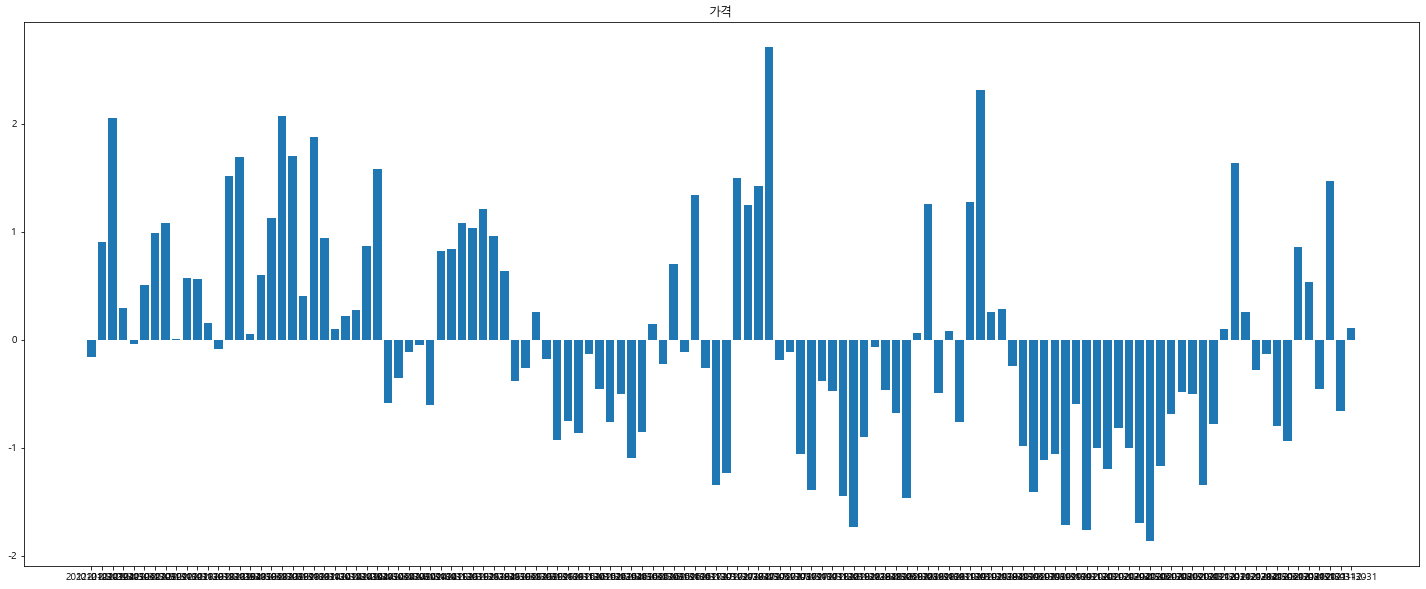

In [785]:
# 가격 바차트


plt.figure(figsize=(25,10))
plt.title('가격')
plt.bar(list_x, price_graph)

<BarContainer object of 120 artists>

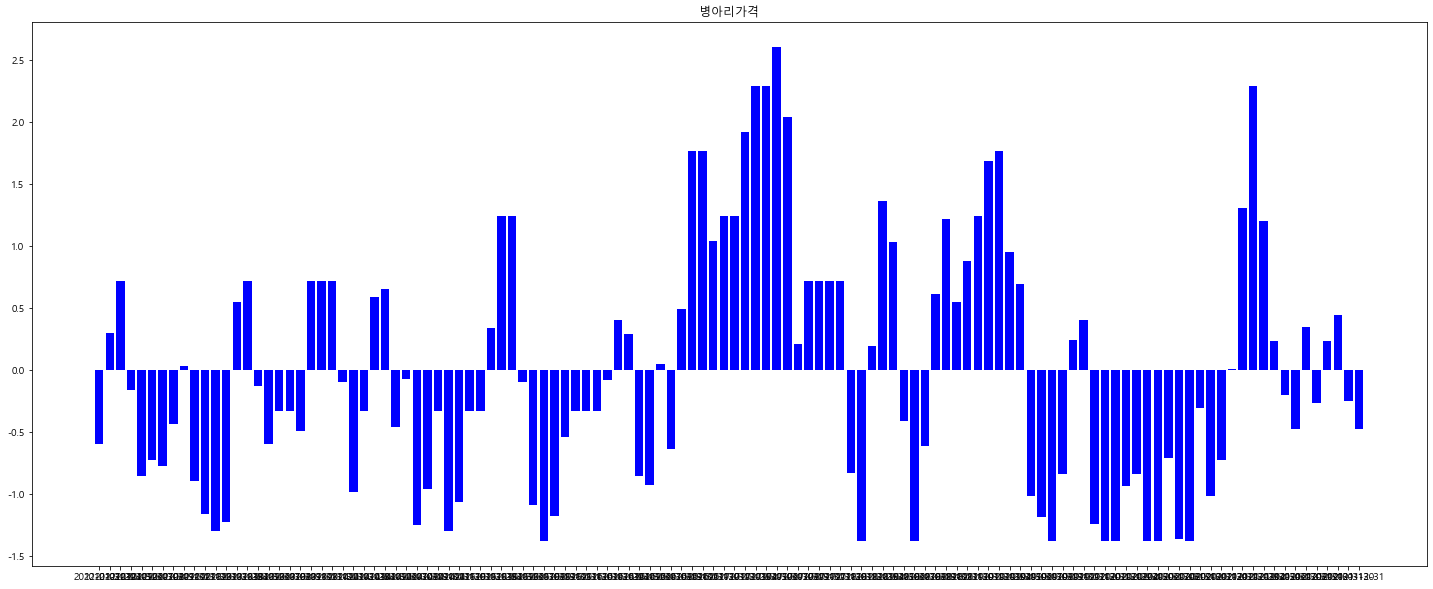

In [786]:
# 병아리가격 바차트
plt.figure(figsize=(25,10))
plt.title('병아리가격')
plt.bar(list_x, chick_graph, color='blue')

<BarContainer object of 120 artists>

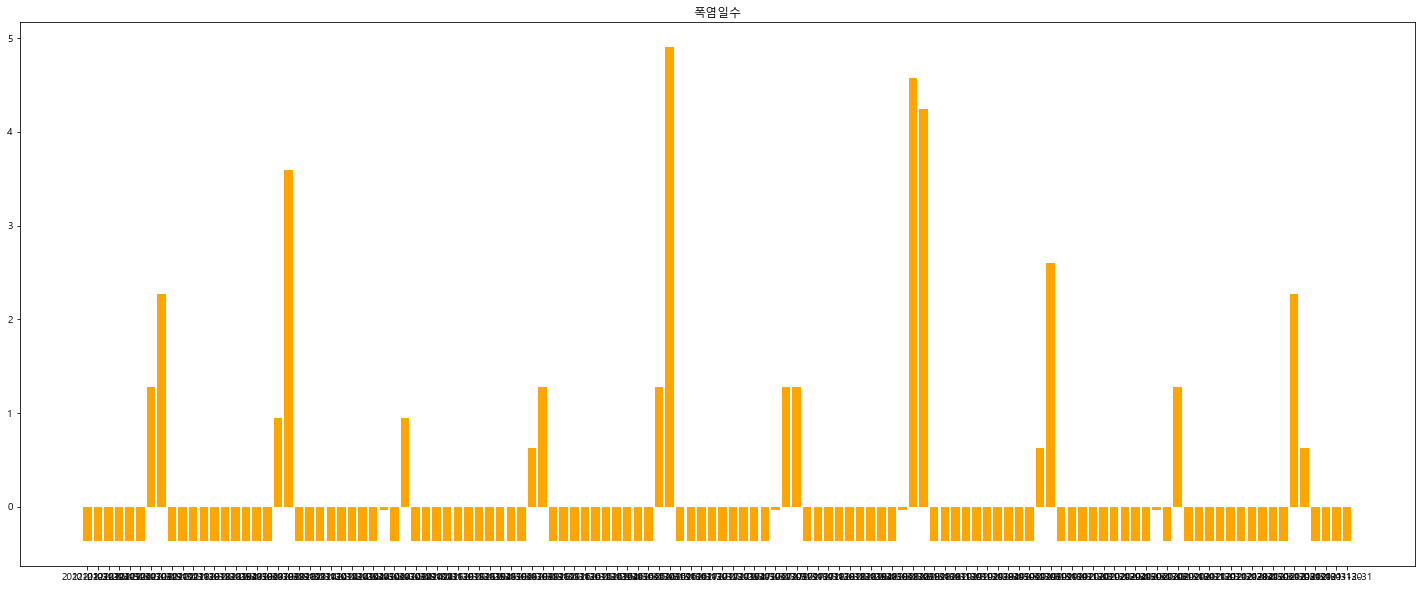

In [787]:
# 기온 바차트
plt.figure(figsize=(25,10))
plt.title('폭염일수')
plt.bar(list_x, hot_day_graph, color='orange')

<BarContainer object of 120 artists>

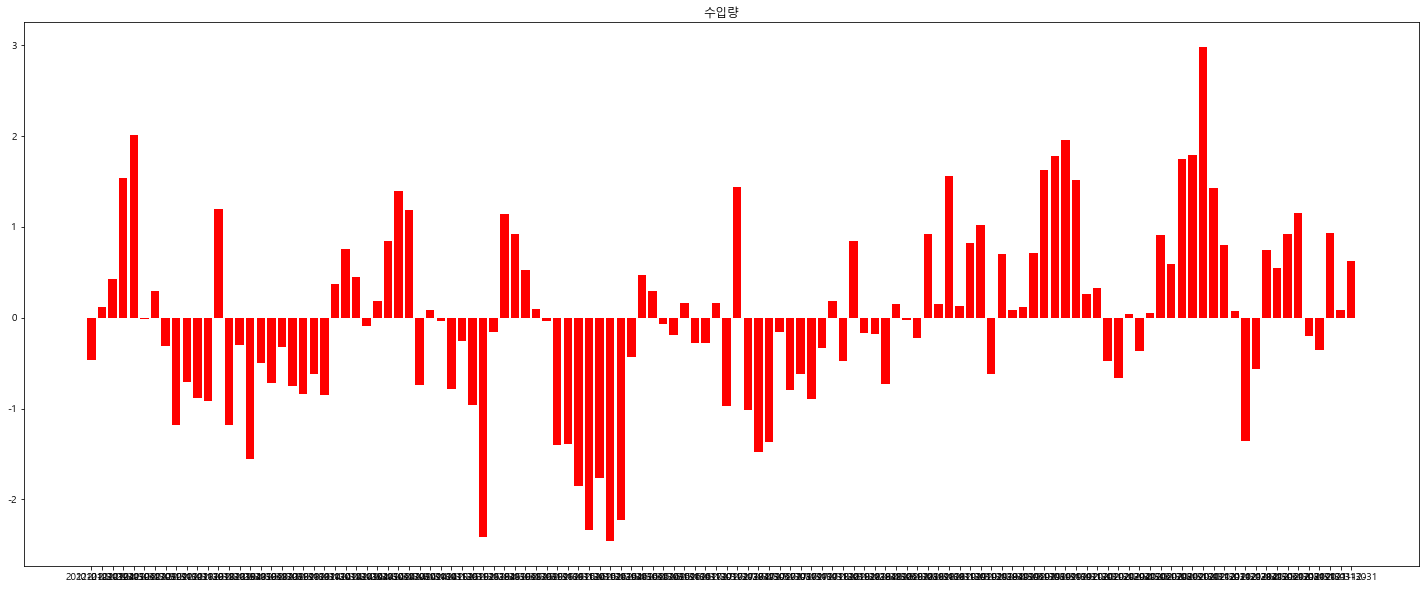

In [788]:
# 수입량 바차트
plt.figure(figsize=(25,10))
plt.title('수입량')
plt.bar(list_x, import_graph, color='red')

<BarContainer object of 120 artists>

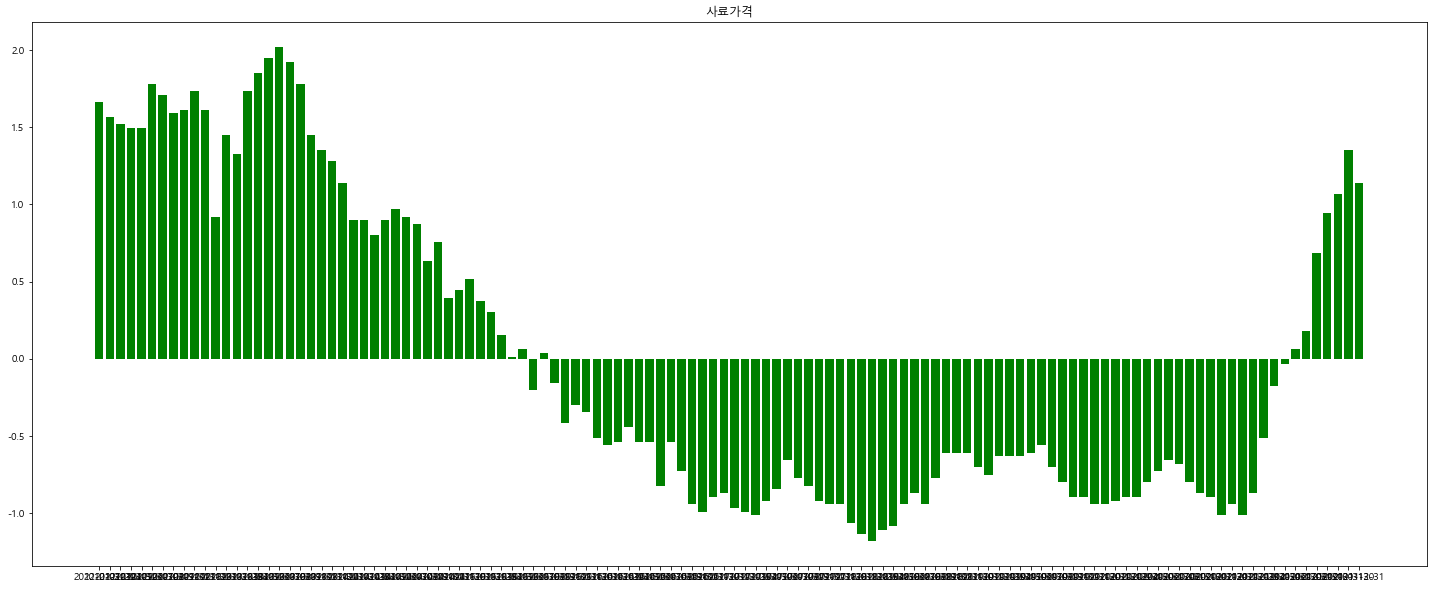

In [789]:
# 사료가격 바차트
plt.figure(figsize=(25,10))
plt.title('사료가격')
plt.bar(list_x, feedprice_graph, color='green')

<BarContainer object of 120 artists>

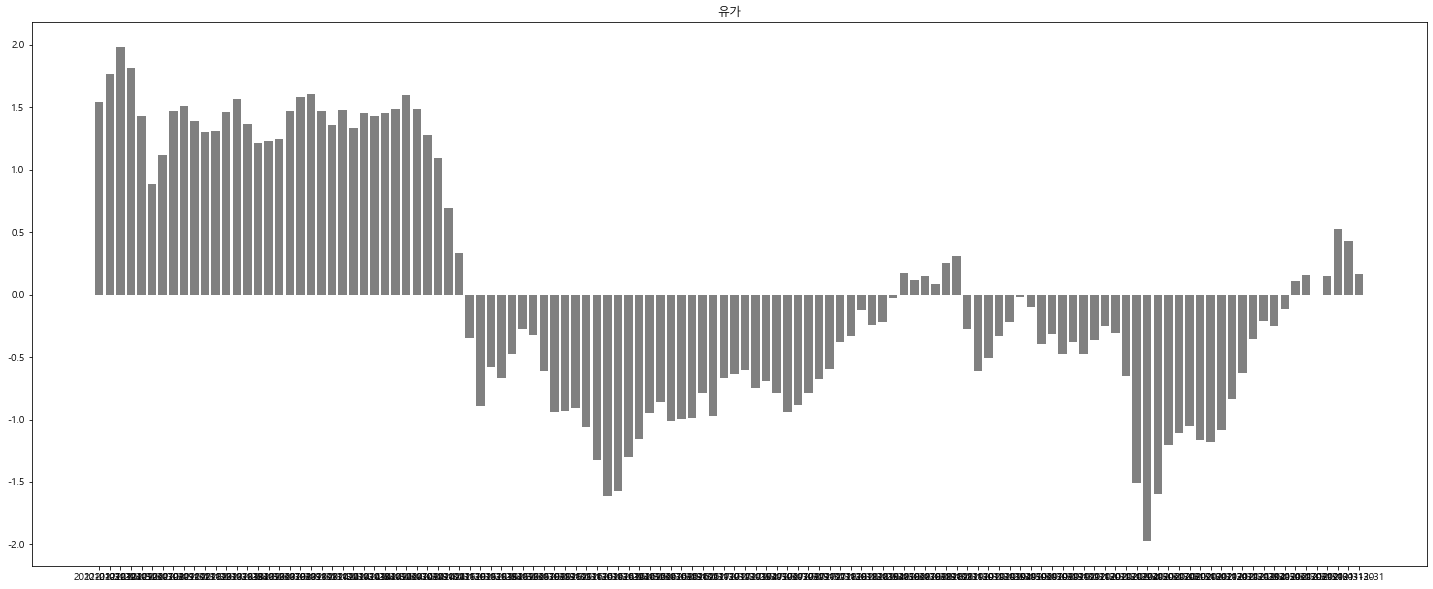

In [790]:
# 유가 바차트
plt.figure(figsize=(25,10))
plt.title('유가')
plt.bar(list_x, oil_graph, color='gray')

<BarContainer object of 120 artists>

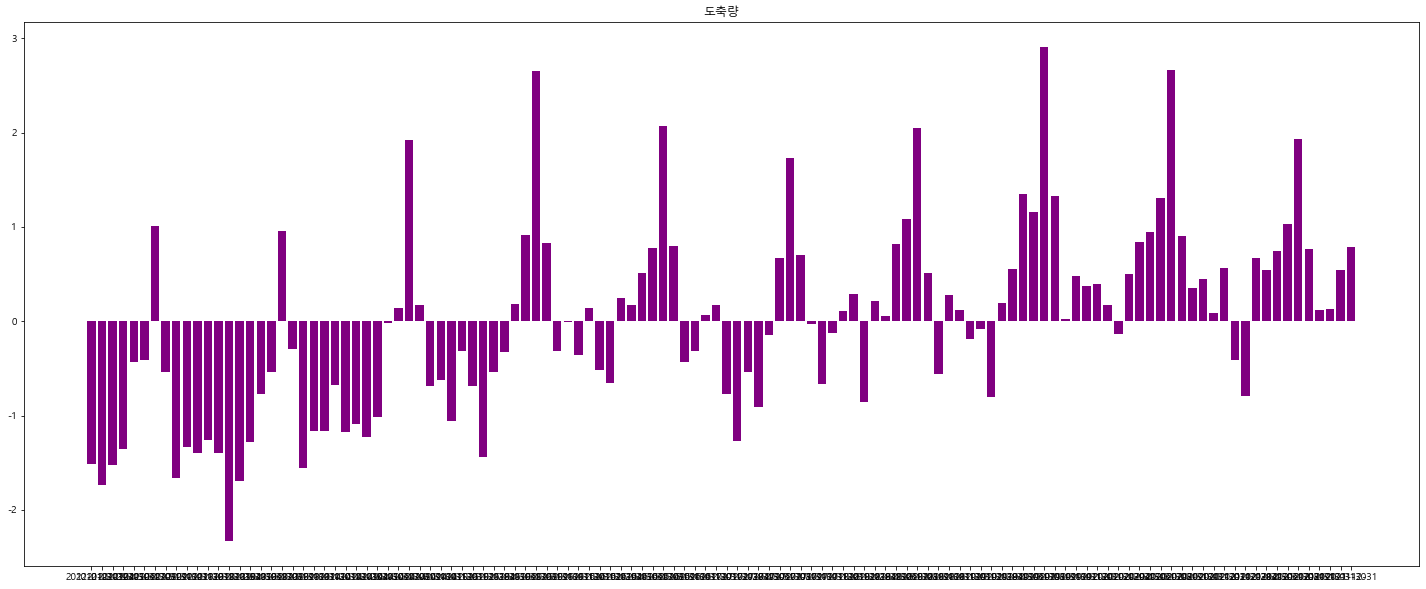

In [791]:
# 도축량 바차트
plt.figure(figsize=(25,10))
plt.title('도축량')
plt.bar(list_x, butchery_graph, color='purple')

<BarContainer object of 120 artists>

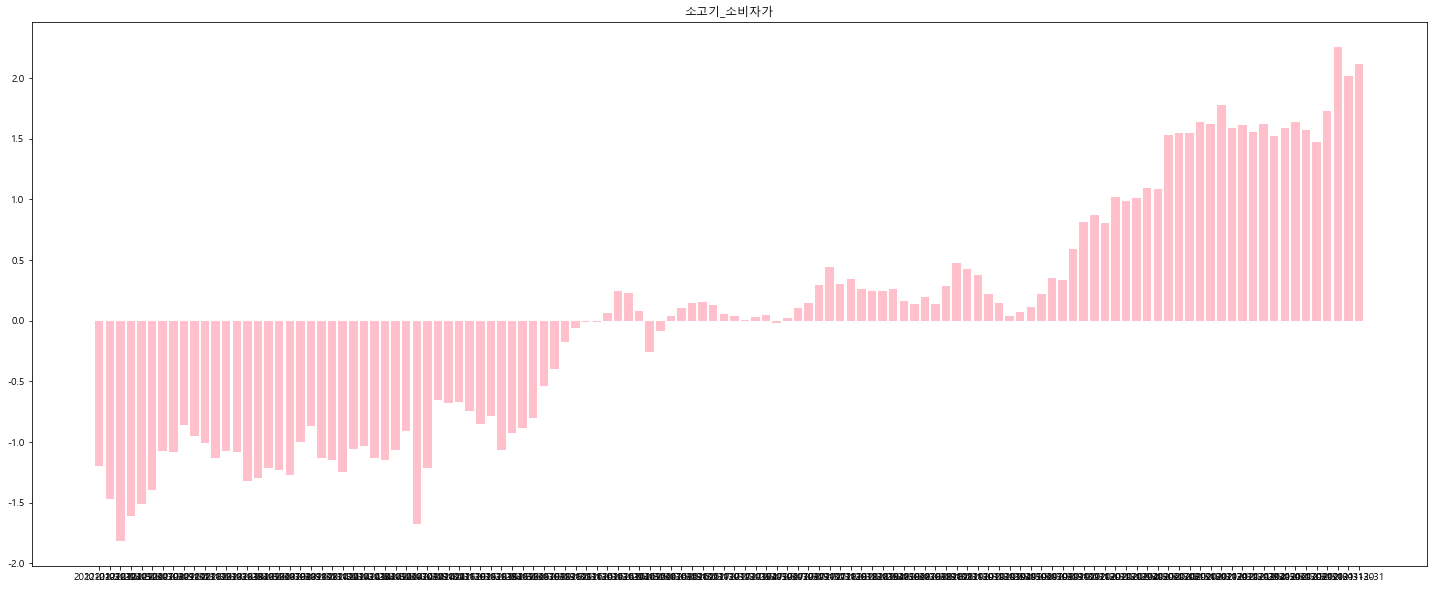

In [792]:
# 소고기_소비자가 바차트
plt.figure(figsize=(25,10))
plt.title('소고기_소비자가')
plt.bar(list_x, cow_graph, color='pink')

<BarContainer object of 120 artists>

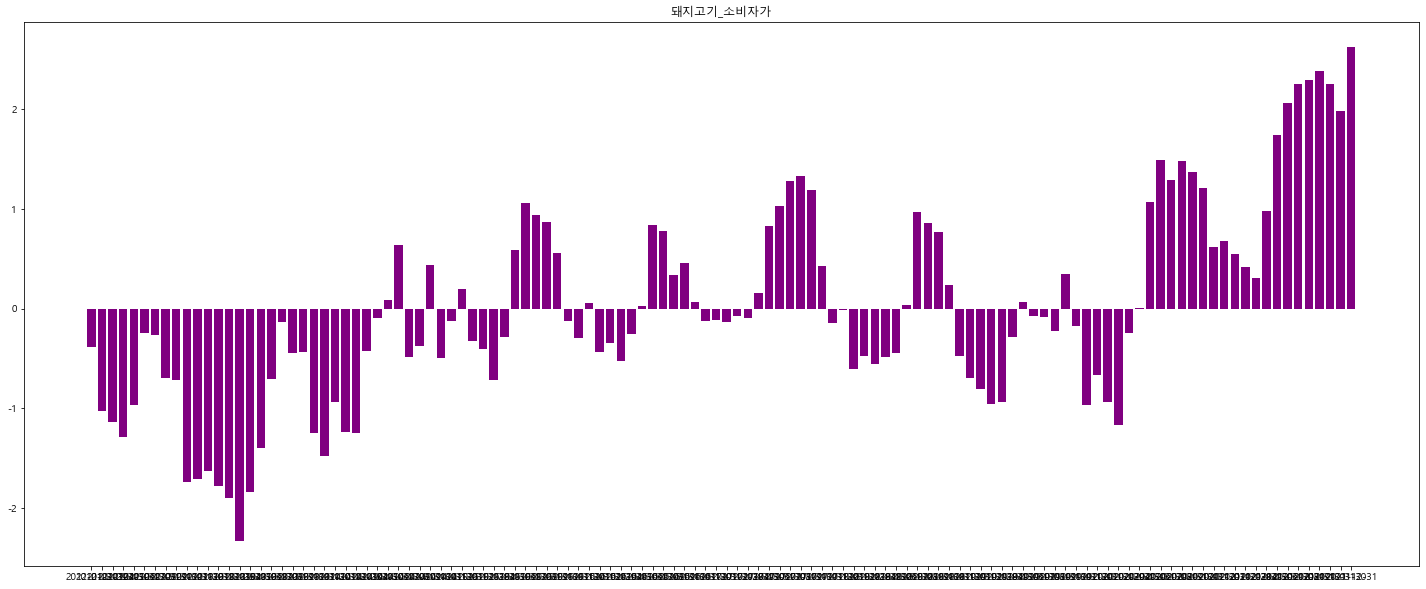

In [793]:
# 돼지고기_소비자가 바차트
plt.figure(figsize=(25,10))
plt.title('돼지고기_소비자가')
plt.bar(list_x, pig_graph, color='purple')

<BarContainer object of 120 artists>

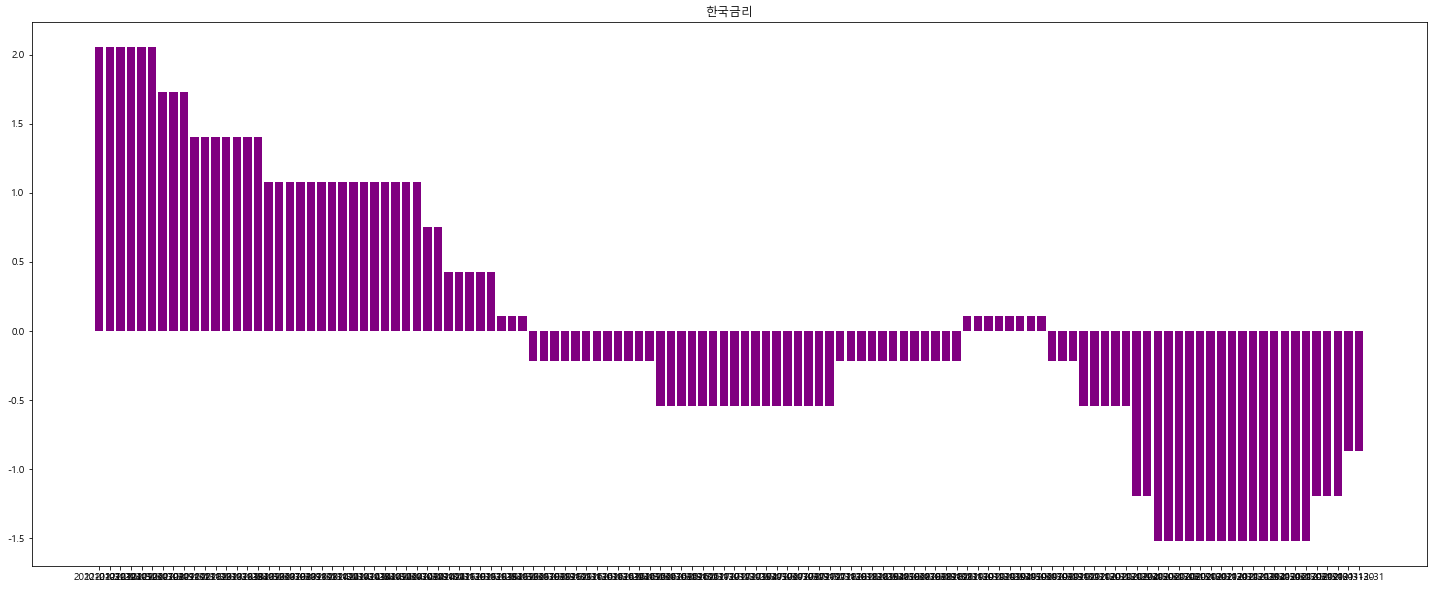

In [794]:
# 한국금리 바차트
plt.figure(figsize=(25,10))
plt.title('한국금리')
plt.bar(list_x, kor_ir_graph, color='purple')

<BarContainer object of 120 artists>

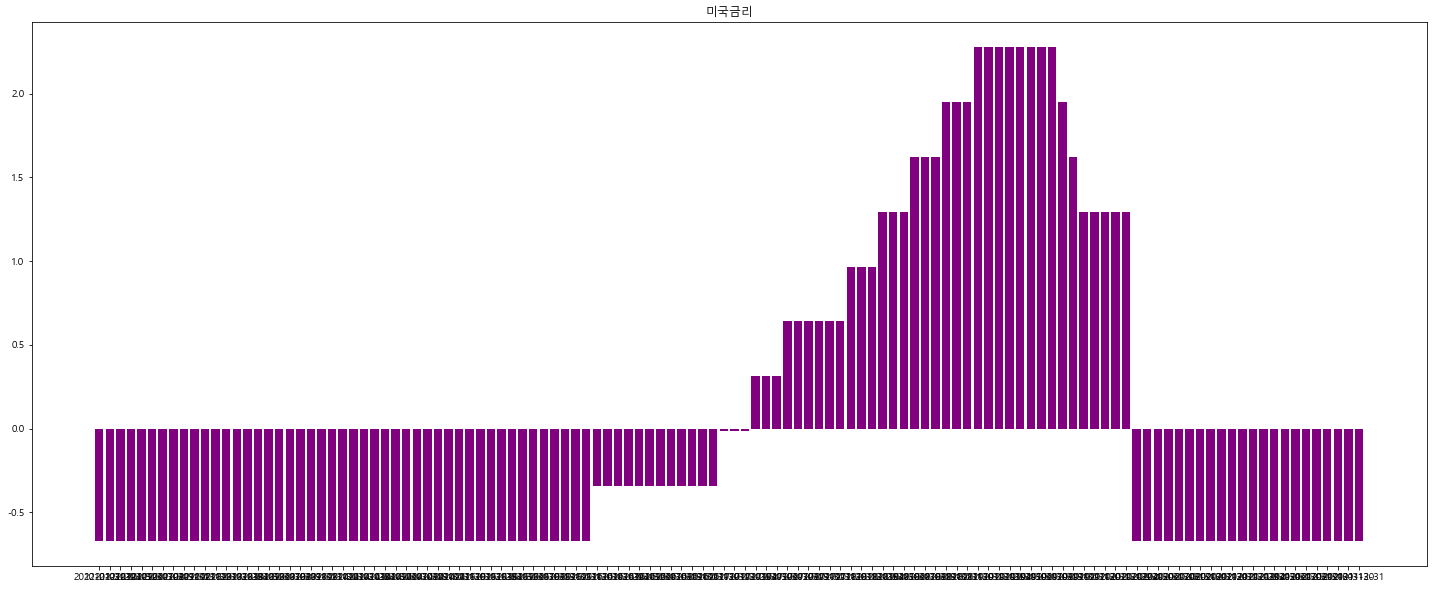

In [795]:
# 미국금리 바차트
plt.figure(figsize=(25,10))
plt.title('미국금리')
plt.bar(list_x, usa_ir_graph, color='purple')

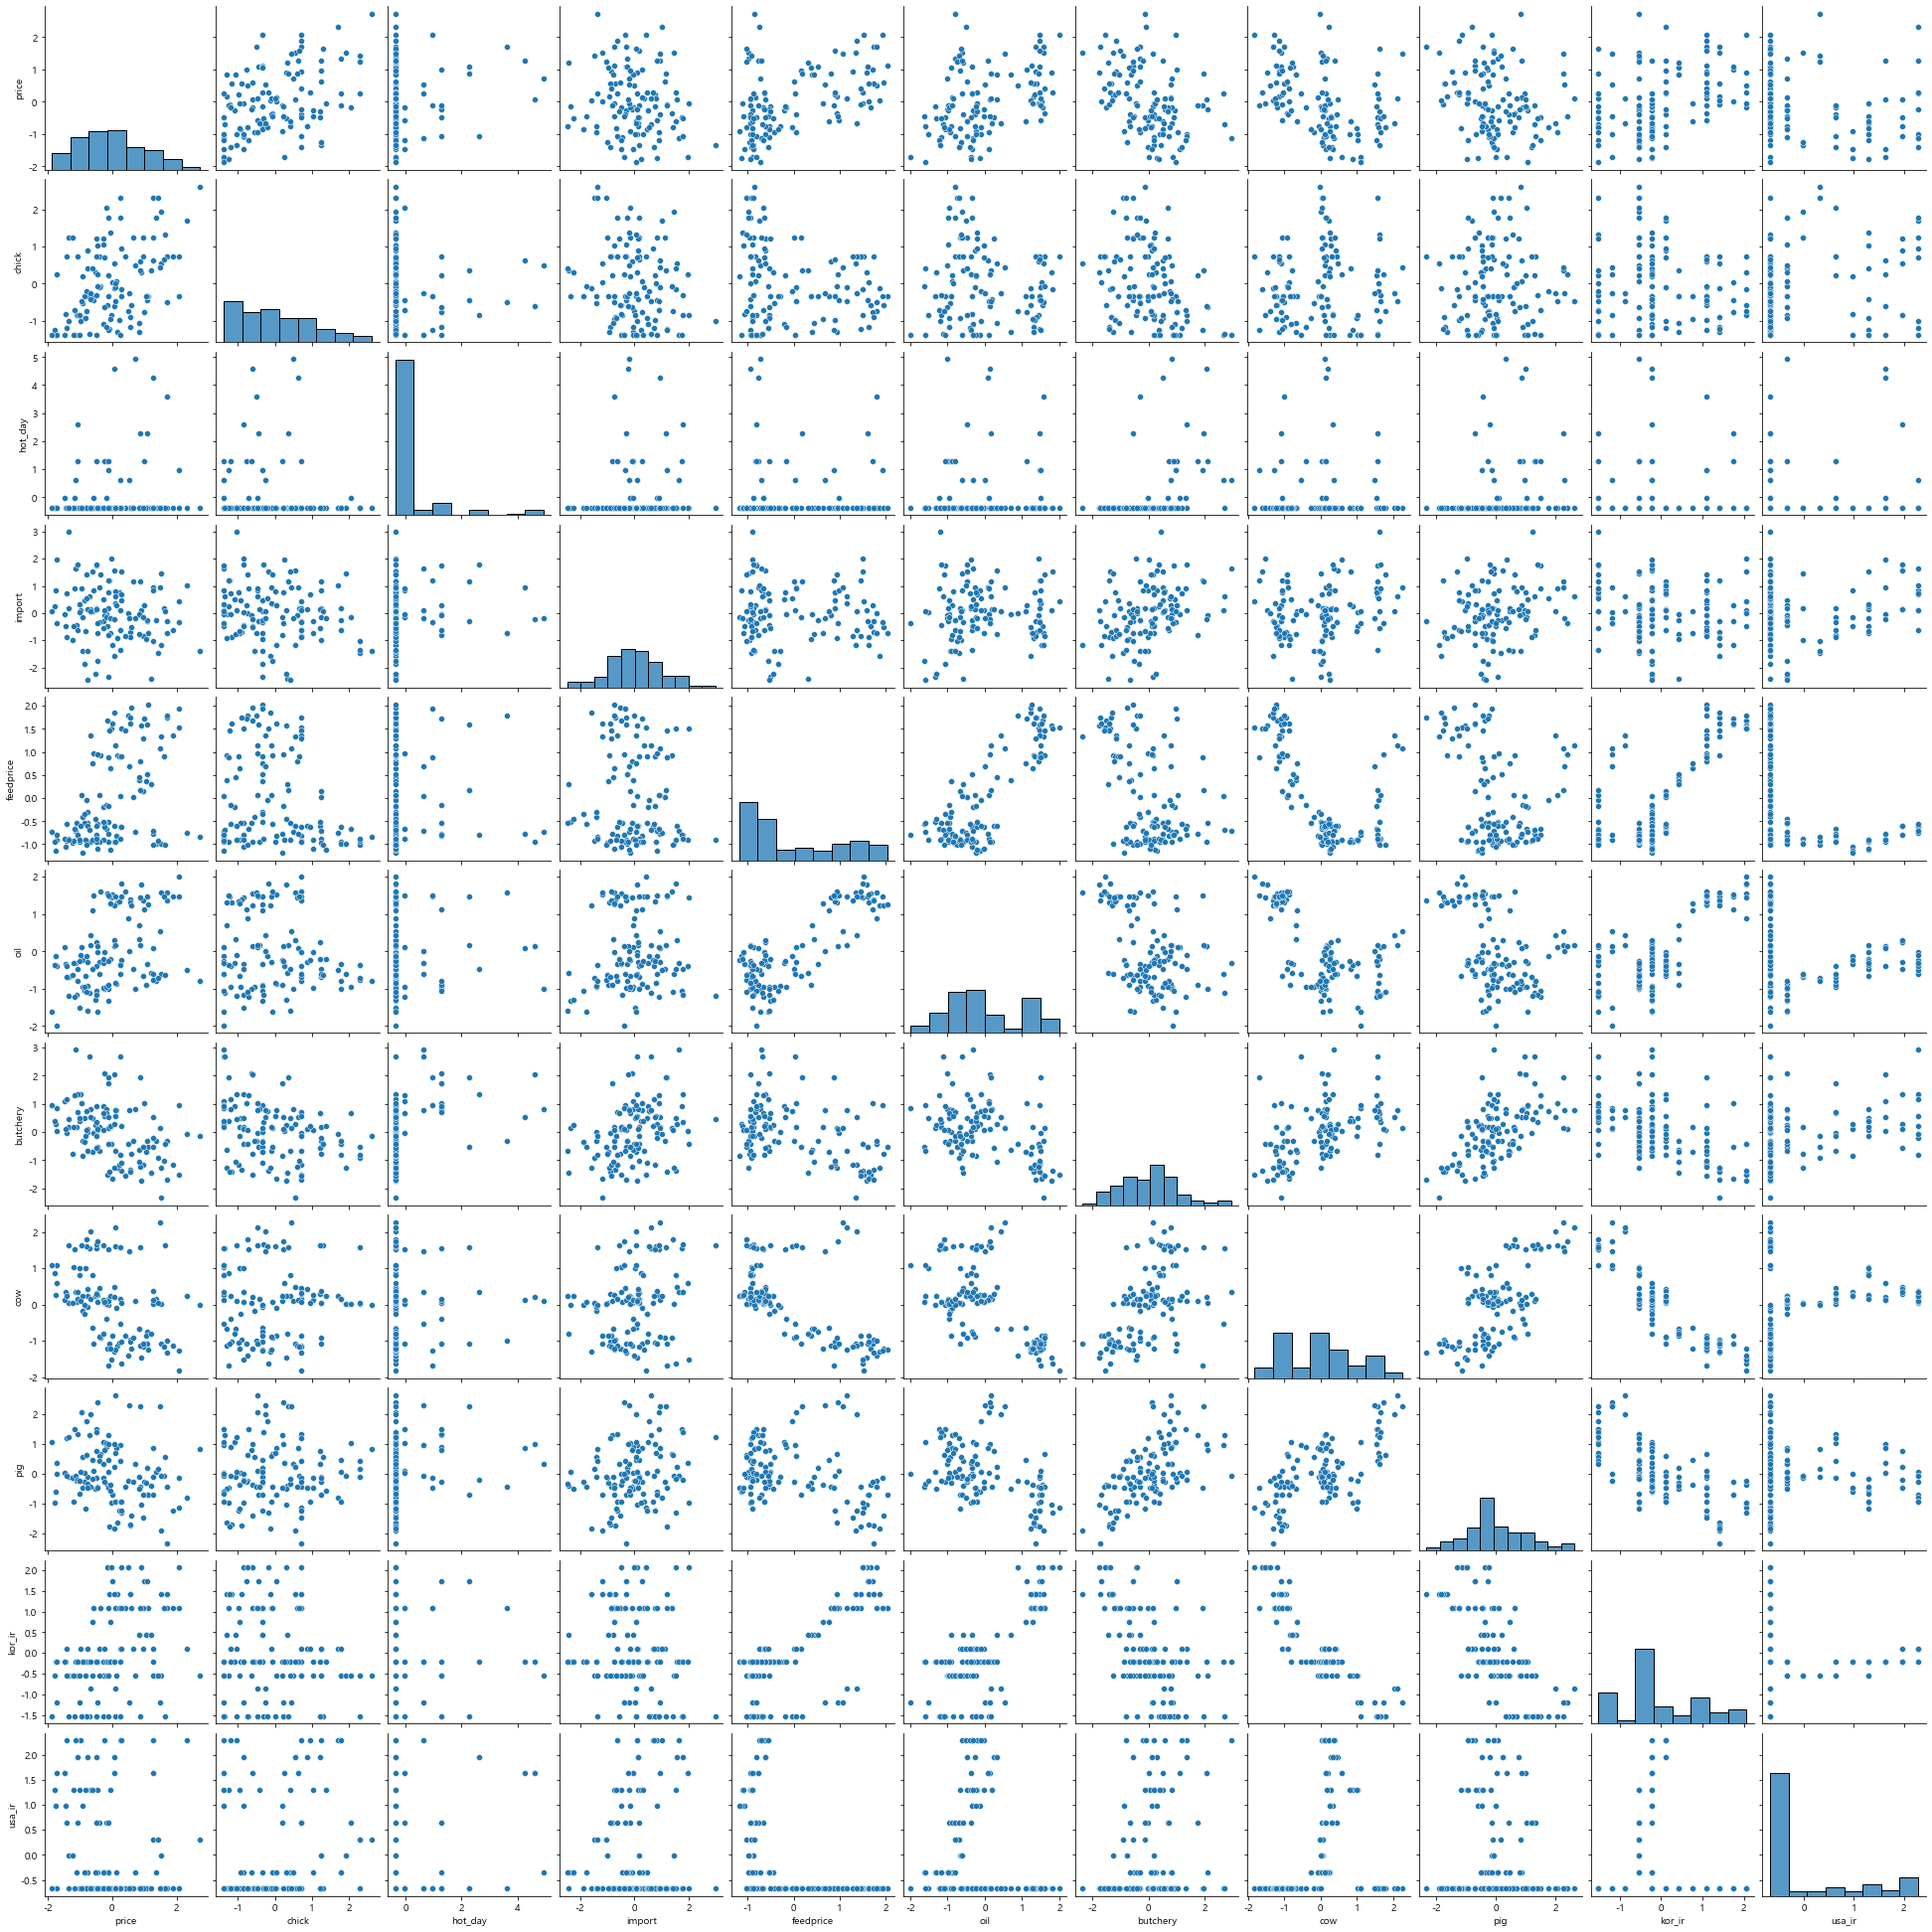

In [808]:
sns.pairplot(month_df, diag_kind='hist')

# K-Means Clustering 시도

## 뭐 때문에 적은 코드지?

In [855]:
# month_df
# price_import = month_df.copy()
# price_import.drop(columns=['date', 'price', 'chick', 'hot_day', 'import', 'feedprice', 'oil',
#        'butchery', 'cow', 'pig', 'kor_ir', 'usa_ir', 'chick_ss',
#        'hot_day_ss', 'feedprice_ss', 'oil_ss', 'butchery_ss',
#        'cow_ss', 'pig_ss', 'kor_ir_ss', 'usa_ir_ss'], inplace=True)
# price_import.info()

# daiy_df
price_import = daily_df.copy()
price_import.drop(columns=['date', 'price', 'chick', 'hot_day', 'import', 'feedprice', 'oil',
       'butchery', 'cow', 'pig', 'kor_ir', 'usa_ir', 'chick_ss',
       'hot_day_ss', 'feedprice_ss', 'oil_ss', 'butchery_ss',
       'cow_ss', 'pig_ss', 'kor_ir_ss', 'usa_ir_ss'], inplace=True)
price_import.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120 entries, 0 to 119
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   price_ss   120 non-null    float64
 1   import_ss  120 non-null    float64
dtypes: float64(2)
memory usage: 2.0 KB


## 주성분 분석

In [178]:
daily_df_dropdate = daily_df.drop(columns=['date'])
pca = PCA(n_components=10) # 데이터의 처음 10개의 주성분만 유지하도록 설정
pca.fit(daily_df_dropdate)
df_pca = pca.transform(daily_df_dropdate)
print('원본데이터 형태 :', str(daily_df_dropdate.shape))
print('축소된 데이터 형태 :', str(df_pca.shape))

원본데이터 형태 : (2094, 16)
축소된 데이터 형태 : (2094, 10)


In [179]:
print('PCA 주성분 형태:', pca.components_.shape)
print('PCA 주성분:', pca.components_)

PCA 주성분 형태: (10, 16)
PCA 주성분: [[ 5.80318914e-03  3.25869505e-03 -1.69463591e-04 -9.92357983e-01
  -1.23212385e-01  1.47550293e-05  3.14840766e-05  3.14357023e-06
   1.15081854e-05  1.48615530e-05 -1.33666946e-05 -8.64648628e-05
  -4.61495193e-05  1.82325069e-05  7.34523456e-05  1.06715256e-05]
 [-3.46084378e-02  2.74654128e-03 -5.66702045e-04  1.22950497e-01
  -9.91805102e-01  1.46249673e-04  3.36657603e-05  7.42697831e-07
  -6.86312832e-05  1.25258326e-05 -4.46994726e-05  1.07127650e-05
  -3.71483181e-04  1.80717918e-04  7.85422132e-05  2.52124760e-06]
 [ 9.66089486e-01  2.56008375e-01  3.35304064e-03  1.04270689e-02
  -3.17116186e-02 -6.07333411e-05 -9.26959260e-06  9.34000649e-05
   1.91583224e-03  1.16754774e-03  2.64476102e-04  9.08517990e-07
  -1.18776692e-05 -7.50470257e-05 -2.16259580e-05  3.17066617e-04]
 [-2.55795121e-01  9.66639074e-01  4.42309836e-03  2.33774779e-04
   1.16292523e-02  2.38017527e-04 -1.53003242e-04  4.72037411e-04
  -5.07262058e-04  4.40843885e-03  3.488785

## 최적군집수 측정

c:\Users\admin\anaconda3\envs\py3_10_4\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\admin\anaconda3\envs\py3_10_4\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\admin\anaconda3\envs\py3_10_4\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\admin\anaconda3\envs\py3_10_4\lib\site-packages\sklearn\cluster\_kmeans.py:1334: User

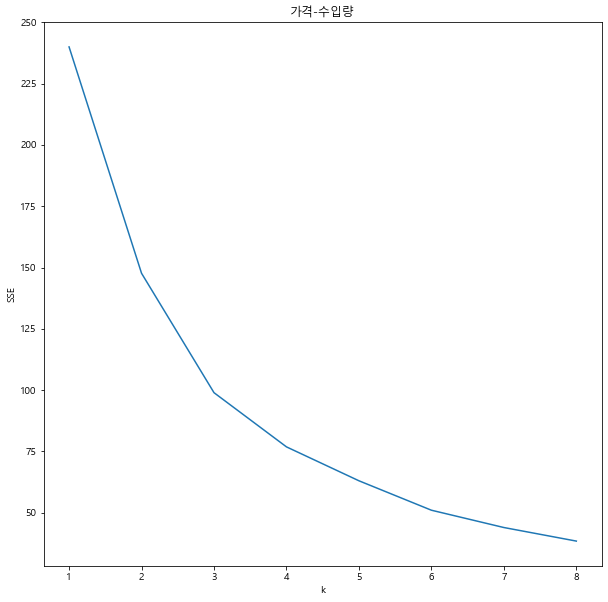

In [856]:
# 최적 군집수 산출
inertia= []
OMP_NUM_THREADS=1
for k in range(1,9):
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(price_import)
    inertia.append(km.inertia_)
plt.figure(figsize=(10,10))
plt.plot(range(1,9), inertia)
plt.title('가격-수입량')
plt.xlabel('k')
plt.ylabel('SSE')
plt.show()

In [84]:
# centroid = 군집 수
centroids = 3

Kmean = KMeans(n_clusters=centroids)
Kmean.fit(price_import)

NameError: name 'price_import' is not defined

In [118]:
Kmean.cluster_centers_

array([[ 3329.11111111,  8074.81481481],
       [ 3301.12      , 11710.6       ],
       [ 3065.92307692, 13911.53846154],
       [ 3317.41666667,  5630.25      ],
       [ 3266.86046512,  9780.97674419]])

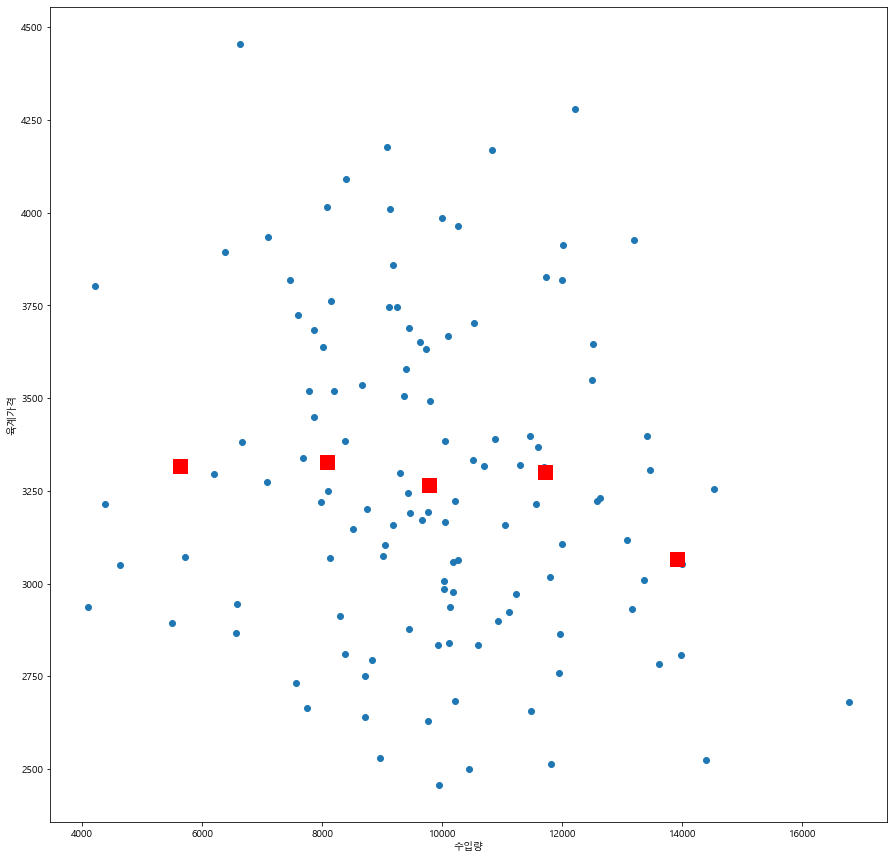

In [119]:
plt.figure(figsize=(15,15))
plt.scatter(price_import['import'],price_import['price'])

plt.scatter(Kmean.cluster_centers_[:,1], Kmean.cluster_centers_[:,0], s=200,  color='red', marker='s')

plt.ylabel('육계가격')
plt.show()

In [237]:
month_df.columns

Index(['date', 'price', 'chick', 'degree', 'hot_day', 'cold_day', 'import',
       'feedprice', 'oil', 'butchery', 'price_ss', 'chick_ss', 'degree_ss',
       'hot_day_ss', 'cold_day_ss', 'import_ss', 'feedprice_ss', 'oil_ss',
       'butchery_ss'],
      dtype='object')

c:\Users\admin\anaconda3\envs\py3_10_4\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\admin\anaconda3\envs\py3_10_4\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\admin\anaconda3\envs\py3_10_4\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\admin\anaconda3\envs\py3_10_4\lib\site-packages\sklearn\cluster\_kmeans.py:1334: User

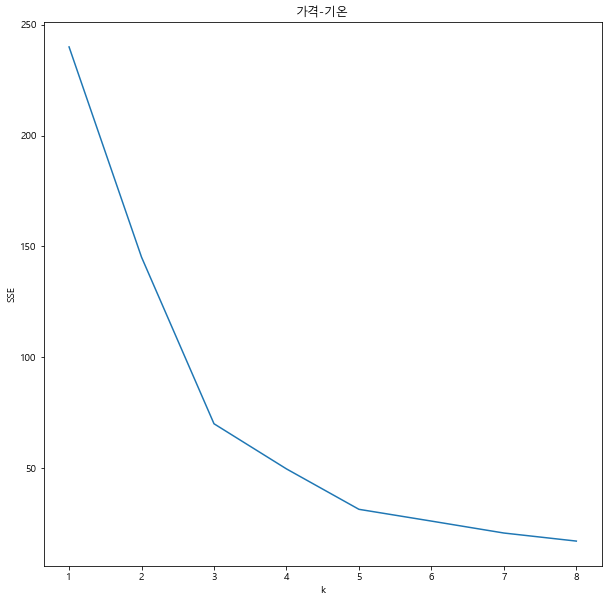

In [857]:
# 가격-폭염일수
price_hot = month_df.copy()
price_hot.drop(columns=['date', 'price', 'chick', 'hot_day', 'import', 'feedprice', 'oil',
       'butchery', 'cow', 'pig', 'kor_ir', 'usa_ir', 'chick_ss',
       'import_ss', 'feedprice_ss', 'oil_ss', 'butchery_ss',
       'cow_ss', 'pig_ss', 'kor_ir_ss', 'usa_ir_ss'], inplace=True)

# 최적 군집수 산출
inertia= []
OMP_NUM_THREADS=1
for k in range(1,9):
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(price_hot)
    inertia.append(km.inertia_)
plt.figure(figsize=(10,10))
plt.plot(range(1,9), inertia)
plt.title('가격-기온')
plt.xlabel('k')
plt.ylabel('SSE')
plt.show()

c:\Users\admin\anaconda3\envs\py3_10_4\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\admin\anaconda3\envs\py3_10_4\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\admin\anaconda3\envs\py3_10_4\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\admin\anaconda3\envs\py3_10_4\lib\site-packages\sklearn\cluster\_kmeans.py:1334: User

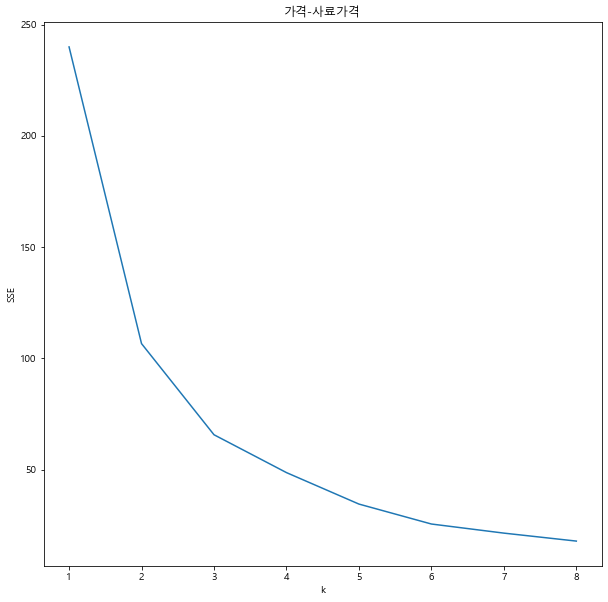

In [861]:
# 가격-사료가격
price_feedprice = month_df.copy()
price_feedprice.drop(columns=['date', 'price', 'chick', 'hot_day', 'import', 'feedprice', 'oil',
       'butchery', 'cow', 'pig', 'kor_ir', 'usa_ir', 'chick_ss',
       'hot_day_ss', 'import_ss', 'oil_ss', 'butchery_ss',
       'cow_ss', 'pig_ss', 'kor_ir_ss', 'usa_ir_ss'], inplace=True)

# 최적 군집수 산출
inertia= []
OMP_NUM_THREADS=1
for k in range(1,9):
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(price_feedprice)
    inertia.append(km.inertia_)
plt.figure(figsize=(10,10))
plt.plot(range(1,9), inertia)
plt.title('가격-사료가격')
plt.xlabel('k')
plt.ylabel('SSE')
plt.show()

c:\Users\admin\anaconda3\envs\py3_10_4\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\admin\anaconda3\envs\py3_10_4\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\admin\anaconda3\envs\py3_10_4\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\admin\anaconda3\envs\py3_10_4\lib\site-packages\sklearn\cluster\_kmeans.py:1334: User

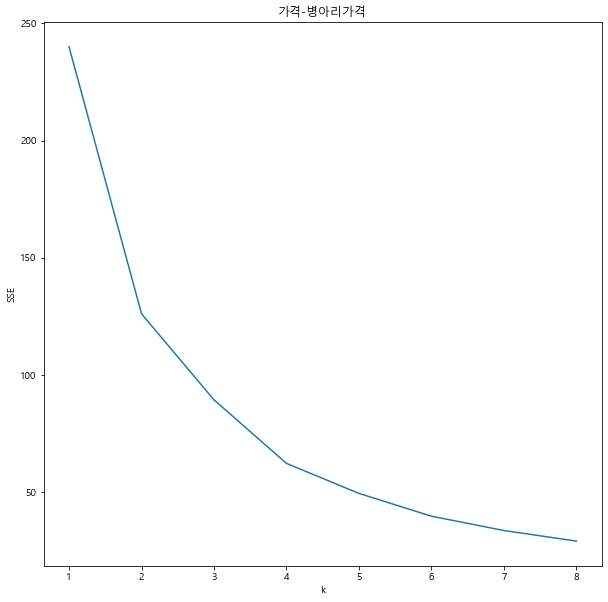

In [862]:
# 가격-병아리가격
price_chick = month_df.copy()
price_chick.drop(columns=['date', 'price', 'chick', 'hot_day', 'import', 'feedprice', 'oil',
       'butchery', 'cow', 'pig', 'kor_ir', 'usa_ir',
       'hot_day_ss', 'import_ss', 'feedprice_ss', 'oil_ss', 'butchery_ss',
       'cow_ss', 'pig_ss', 'kor_ir_ss', 'usa_ir_ss'], inplace=True)

# 최적 군집수 산출
inertia= []
OMP_NUM_THREADS=1
for k in range(1,9):
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(price_chick)
    inertia.append(km.inertia_)
plt.figure(figsize=(10,10))
plt.plot(range(1,9), inertia)
plt.title('가격-병아리가격')
plt.xlabel('k')
plt.ylabel('SSE')
plt.show()

c:\Users\admin\anaconda3\envs\py3_10_4\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\admin\anaconda3\envs\py3_10_4\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\admin\anaconda3\envs\py3_10_4\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\admin\anaconda3\envs\py3_10_4\lib\site-packages\sklearn\cluster\_kmeans.py:1334: User

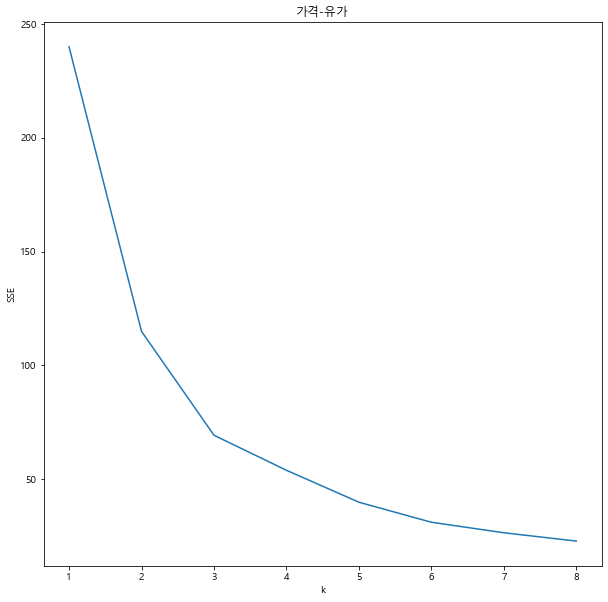

In [863]:
# 가격-유가
price_oil = month_df.copy()
price_oil.drop(columns=['date', 'price', 'chick', 'hot_day', 'import', 'feedprice', 'oil',
       'butchery', 'cow', 'pig', 'kor_ir', 'usa_ir', 'chick_ss',
       'hot_day_ss', 'import_ss', 'feedprice_ss', 'butchery_ss',
       'cow_ss', 'pig_ss', 'kor_ir_ss', 'usa_ir_ss'], inplace=True)

# 최적 군집수 산출
inertia= []
OMP_NUM_THREADS=1
for k in range(1,9):
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(price_oil)
    inertia.append(km.inertia_)
plt.figure(figsize=(10,10))
plt.plot(range(1,9), inertia)
plt.title('가격-유가')
plt.xlabel('k')
plt.ylabel('SSE')
plt.show()

c:\Users\admin\anaconda3\envs\py3_10_4\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\admin\anaconda3\envs\py3_10_4\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\admin\anaconda3\envs\py3_10_4\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\admin\anaconda3\envs\py3_10_4\lib\site-packages\sklearn\cluster\_kmeans.py:1334: User

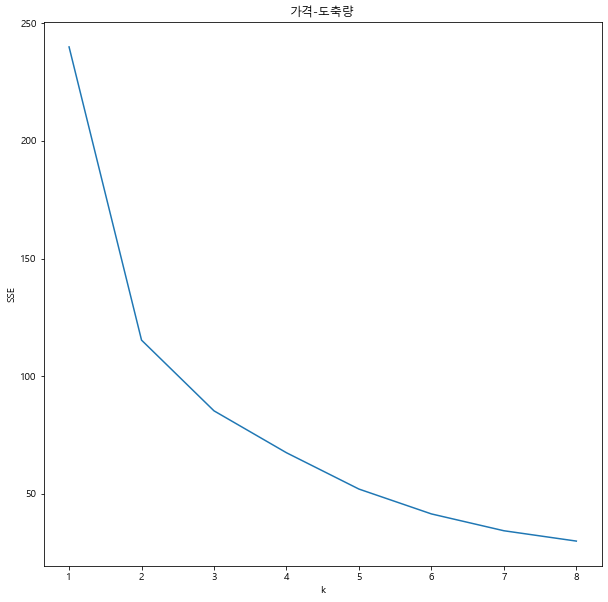

In [864]:
# 가격-도축량
price_butchery = month_df.copy()
price_butchery.drop(columns=['date', 'price', 'chick', 'hot_day', 'import', 'feedprice', 'oil',
       'butchery', 'cow', 'pig', 'kor_ir', 'usa_ir', 'chick_ss',
       'hot_day_ss', 'import_ss', 'feedprice_ss', 'oil_ss',
       'cow_ss', 'pig_ss', 'kor_ir_ss', 'usa_ir_ss'], inplace=True)

# 최적 군집수 산출
inertia= []
OMP_NUM_THREADS=1
for k in range(1,9):
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(price_butchery)
    inertia.append(km.inertia_)
plt.figure(figsize=(10,10))
plt.plot(range(1,9), inertia)
plt.title('가격-도축량')
plt.xlabel('k')
plt.ylabel('SSE')
plt.show()

c:\Users\admin\anaconda3\envs\py3_10_4\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\admin\anaconda3\envs\py3_10_4\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\admin\anaconda3\envs\py3_10_4\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\admin\anaconda3\envs\py3_10_4\lib\site-packages\sklearn\cluster\_kmeans.py:1334: User

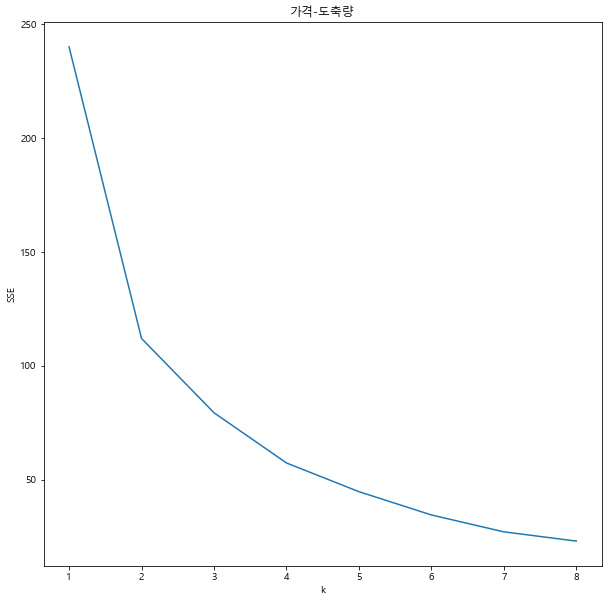

In [865]:
# 가격-소
price_cow = month_df.copy()
price_cow.drop(columns=['date', 'price', 'chick', 'hot_day', 'import', 'feedprice', 'oil',
       'butchery', 'cow', 'pig', 'kor_ir', 'usa_ir', 'chick_ss',
       'hot_day_ss', 'import_ss', 'feedprice_ss', 'oil_ss', 'butchery_ss',
       'pig_ss', 'kor_ir_ss', 'usa_ir_ss'], inplace=True)

# 최적 군집수 산출
inertia= []
OMP_NUM_THREADS=1
for k in range(1,9):
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(price_cow)
    inertia.append(km.inertia_)
plt.figure(figsize=(10,10))
plt.plot(range(1,9), inertia)
plt.title('가격-도축량')
plt.xlabel('k')
plt.ylabel('SSE')
plt.show()

c:\Users\admin\anaconda3\envs\py3_10_4\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\admin\anaconda3\envs\py3_10_4\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\admin\anaconda3\envs\py3_10_4\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\admin\anaconda3\envs\py3_10_4\lib\site-packages\sklearn\cluster\_kmeans.py:1334: User

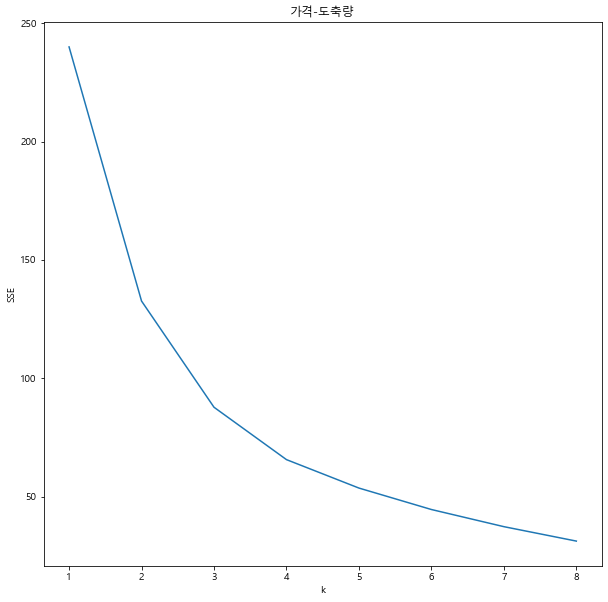

In [866]:
# 가격-돼지
price_pig = month_df.copy()
price_pig.drop(columns=['date', 'price', 'chick', 'hot_day', 'import', 'feedprice', 'oil',
       'butchery', 'cow', 'pig', 'kor_ir', 'usa_ir', 'chick_ss',
       'hot_day_ss', 'import_ss', 'feedprice_ss', 'oil_ss', 'butchery_ss',
       'cow_ss', 'kor_ir_ss', 'usa_ir_ss'], inplace=True)

# 최적 군집수 산출
inertia= []
OMP_NUM_THREADS=1
for k in range(1,9):
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(price_pig)
    inertia.append(km.inertia_)
plt.figure(figsize=(10,10))
plt.plot(range(1,9), inertia)
plt.title('가격-도축량')
plt.xlabel('k')
plt.ylabel('SSE')
plt.show()

c:\Users\admin\anaconda3\envs\py3_10_4\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\admin\anaconda3\envs\py3_10_4\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\admin\anaconda3\envs\py3_10_4\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\admin\anaconda3\envs\py3_10_4\lib\site-packages\sklearn\cluster\_kmeans.py:1334: User

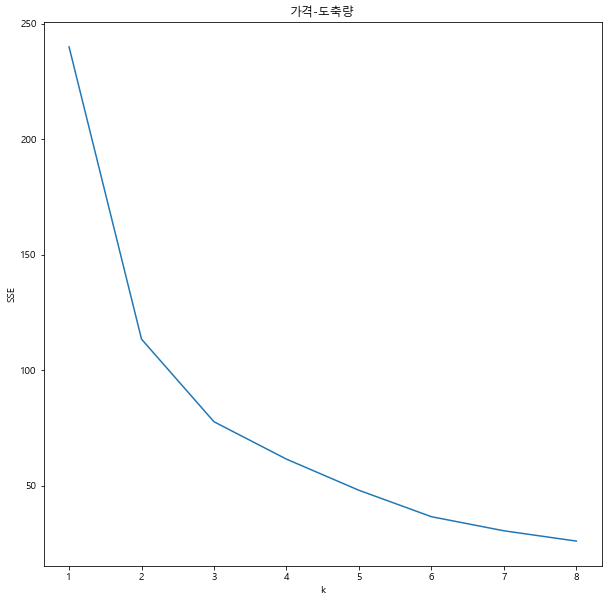

In [867]:
# 가격-금리
price_korir = month_df.copy()
price_korir.drop(columns=['date', 'price', 'chick', 'hot_day', 'import', 'feedprice', 'oil',
       'butchery', 'cow', 'pig', 'kor_ir', 'usa_ir', 'chick_ss',
       'hot_day_ss', 'import_ss', 'feedprice_ss', 'oil_ss', 'butchery_ss',
       'cow_ss', 'pig_ss', 'usa_ir_ss'], inplace=True)

# 최적 군집수 산출
inertia= []
OMP_NUM_THREADS=1
for k in range(1,9):
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(price_korir)
    inertia.append(km.inertia_)
plt.figure(figsize=(10,10))
plt.plot(range(1,9), inertia)
plt.title('가격-도축량')
plt.xlabel('k')
plt.ylabel('SSE')
plt.show()

c:\Users\admin\anaconda3\envs\py3_10_4\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\admin\anaconda3\envs\py3_10_4\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\admin\anaconda3\envs\py3_10_4\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\admin\anaconda3\envs\py3_10_4\lib\site-packages\sklearn\cluster\_kmeans.py:1334: User

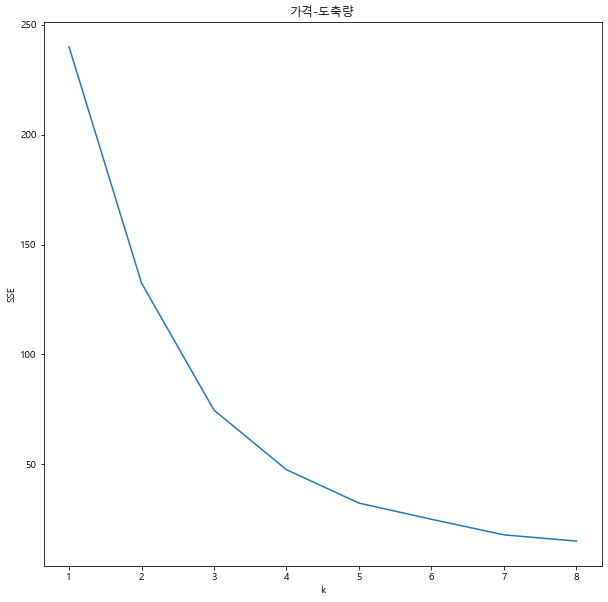

In [868]:
# 가격-미금리
price_usair = month_df.copy()
price_usair.drop(columns=['date', 'price', 'chick', 'hot_day', 'import', 'feedprice', 'oil',
       'butchery', 'cow', 'pig', 'kor_ir', 'usa_ir', 'price_ss',
       'hot_day_ss', 'import_ss', 'feedprice_ss', 'oil_ss', 'butchery_ss',
       'cow_ss', 'pig_ss', 'kor_ir_ss'], inplace=True)

# 최적 군집수 산출
inertia= []
OMP_NUM_THREADS=1
for k in range(1,9):
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(price_usair)
    inertia.append(km.inertia_)
plt.figure(figsize=(10,10))
plt.plot(range(1,9), inertia)
plt.title('가격-도축량')
plt.xlabel('k')
plt.ylabel('SSE')
plt.show()

## 클러스터링 진행

In [19]:
# df_forkmeans = month_df.drop(columns=['date', 'price', 'chick', 'hot_day', 'import', 'feedprice', 'oil',
#        'butchery', 'cow', 'pig', 'kor_ir', 'usa_ir'])
# df_forkmeans


# 원본
# df_forkmeans = daily_df.drop(columns=['date', 'price_ss', 'chick_ss','oil_ss','cow_ss','pig_ss','usa_ir_ss','kor_ir_ss'])
# df_forkmeans.describe()

# 정규화 테이블
df_forkmeans = daily_df_ss.drop(columns=['price_ss', 'chick','oil','cow','pig','ai','usa_ir','kor_ir','ai_ss'])
# df_forkmeans.describe()
df_forkmeans

,date,price,chick_ss,oil_ss,cow_ss,pig_ss,usa_ir_ss,kor_ir_ss
1,2012-01-03,3118.0,0.250,0.834598,0.173490,0.531012,0.222222,1.000000
2,2012-01-04,3118.0,0.250,0.857904,0.184105,0.529242,0.222222,1.000000
3,2012-01-05,3118.0,0.125,0.873622,0.139267,0.501505,0.222222,1.000000
4,2012-01-06,3166.0,0.125,0.870822,0.131504,0.486161,0.222222,1.000000
5,2012-01-07,3319.0,0.125,0.870822,0.131504,0.486161,0.222222,1.000000
...,...,...,...,...,...,...,...,...
2991,2021-12-27,3743.0,0.375,0.559169,0.937084,0.924225,0.000000,0.181818
2992,2021-12-28,3895.0,0.375,0.568654,0.963068,0.920862,0.000000,0.181818
2993,2021-12-29,3895.0,0.375,0.572629,0.981352,0.918206,0.000000,0.181818
2994,2021-12-30,4047.0,0.375,0.575610,0.971481,0.830865,0.000000,0.181818


In [20]:
# 원본테이블
# df_forkmeans['total'] = df_forkmeans['chick']*0.53 + df_forkmeans['kor_ir']*0.34 + df_forkmeans['oil']*0.36 + df_forkmeans['cow']*(-0.36) + df_forkmeans['usa_ir']*(-0.22)


#정규화테이블
df_forkmeans['total'] = (df_forkmeans['chick_ss']*0.8)**2 + (df_forkmeans['oil_ss']*0.53)**2 +  (df_forkmeans['kor_ir_ss']*0.8)**2 + (df_forkmeans['usa_ir_ss']*(-0.22))**2
# 여기서 넣고 꺼내기
#  + df_forkmeans['pig_ss']*0.06 + df_forkmeans['cow_ss']*(-0.36)

# df_forkmeans = df_forkmeans.drop(columns=['chick_ss','oil_ss','cow_ss','pig_ss','usa_ir_ss','kor_ir_ss','ai_ss'])

# df_forkmeans.drop(columns=['chick_ss','oil_ss','cow_ss','pig_ss','usa_ir_ss','kor_ir_ss'], inplace=True)
df_forkmeans

,date,price,chick_ss,oil_ss,cow_ss,pig_ss,usa_ir_ss,kor_ir_ss,total
1,2012-01-03,3118.0,0.250,0.834598,0.173490,0.531012,0.222222,1.000000,0.878052
2,2012-01-04,3118.0,0.250,0.857904,0.184105,0.529242,0.222222,1.000000,0.889132
3,2012-01-05,3118.0,0.125,0.873622,0.139267,0.501505,0.222222,1.000000,0.866778
4,2012-01-06,3166.0,0.125,0.870822,0.131504,0.486161,0.222222,1.000000,0.865405
5,2012-01-07,3319.0,0.125,0.870822,0.131504,0.486161,0.222222,1.000000,0.865405
...,...,...,...,...,...,...,...,...,...
2991,2021-12-27,3743.0,0.375,0.559169,0.937084,0.924225,0.000000,0.181818,0.198986
2992,2021-12-28,3895.0,0.375,0.568654,0.963068,0.920862,0.000000,0.181818,0.201991
2993,2021-12-29,3895.0,0.375,0.572629,0.981352,0.918206,0.000000,0.181818,0.203265
2994,2021-12-30,4047.0,0.375,0.575610,0.971481,0.830865,0.000000,0.181818,0.204227


In [21]:
df_forkmeans = df_forkmeans[["date","price","total"]]
df_forkmeans

,date,price,total
1,2012-01-03,3118.0,0.878052
2,2012-01-04,3118.0,0.889132
3,2012-01-05,3118.0,0.866778
4,2012-01-06,3166.0,0.865405
5,2012-01-07,3319.0,0.865405
...,...,...,...
2991,2021-12-27,3743.0,0.198986
2992,2021-12-28,3895.0,0.201991
2993,2021-12-29,3895.0,0.203265
2994,2021-12-30,4047.0,0.204227


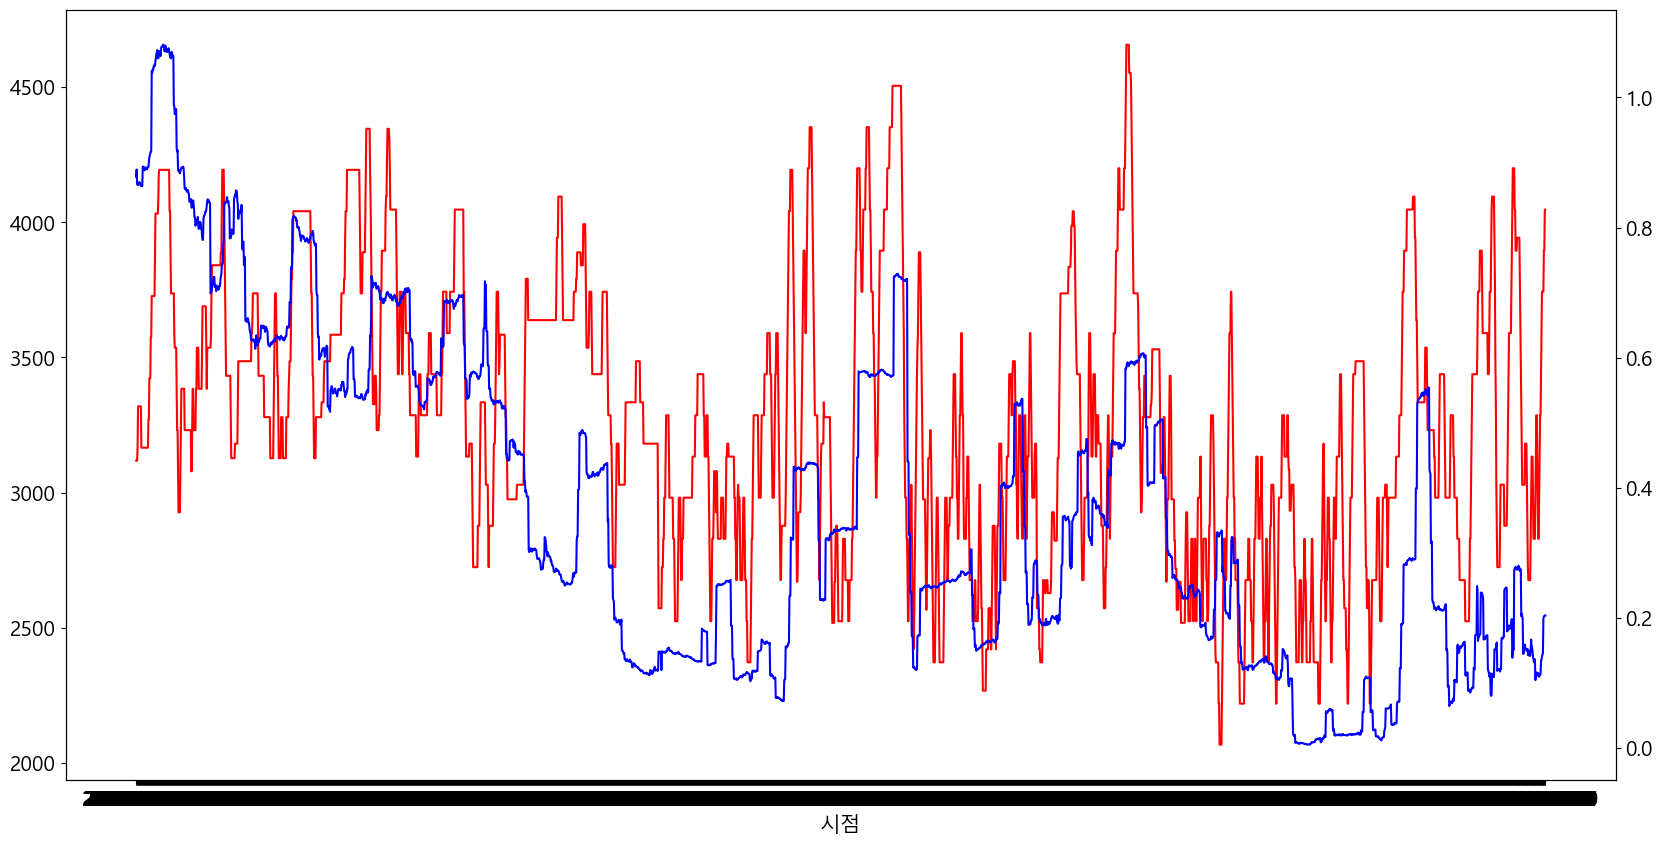

In [27]:
plt.style.use('default')
plt.rcParams['figure.figsize'] = (20,10)
plt.rcParams['font.size'] = 15
plt.rcParams['font.family'] = font_name

x = df_forkmeans['date']
y1 = df_forkmeans['price']
y2 = df_forkmeans['total']

fig, ax1 = plt.subplots()
# ax1.set_title('월별 닭고기, 수입량 그래프')
ax1.set_xlabel('시점')
# ax1.set_ylabel('닭고기 가격')
ax1.plot(x, y1, color='red',label='price')

ax2 = ax1.twinx()
# ax2.set_ylabel('수입량')
ax2.plot(x, y2, color='blue',label='total')
# plt.xticks(['2012-01-01', '2013-01-01', '2014-01-01','2015-01-01','2016-01-01','2017-01-01', '2018-01-01', '2019-01-01', '2020-01-01', '2021-01-01'])
plt.show()

In [288]:
df_forkmeans.to_csv('./pre_data/몰라_utf8.csv', encoding='utf8', index=False)

In [18]:
# 적절한 군집수 3을 가지고 군집 예측값 생성

cluster_model = KMeans(n_clusters=10,        # =k
                       n_init=3,           # centroid를 몇번 샘플링한건지, 많이 돌릴수록 안정화된 결과가 나옴
                       max_iter=500,        # K-Means를 몇번 반복 수행할건지
                       random_state=42)

cluster_model.fit(df_forkmeans)

centers = cluster_model.cluster_centers_    # 각 군집의 중심점
pred = cluster_model.predict(df_forkmeans)     # 각 예측군집

print(pd.DataFrame(centers))
print(pred[:10])

ValueError: could not convert string to float: '2012-01-03'

In [16]:
cluster_df = df_forkmeans.copy()
cluster_df['clust'] = pred
cluster_df

,price,chick_ss,oil_ss,cow_ss,pig_ss,usa_ir_ss,kor_ir_ss,total,clust
1,3118.0,0.250,0.834598,0.173490,0.531012,0.222222,1.000000,0.878052,8
2,3118.0,0.250,0.857904,0.184105,0.529242,0.222222,1.000000,0.889132,8
3,3118.0,0.125,0.873622,0.139267,0.501505,0.222222,1.000000,0.866778,8
4,3166.0,0.125,0.870822,0.131504,0.486161,0.222222,1.000000,0.865405,8
5,3319.0,0.125,0.870822,0.131504,0.486161,0.222222,1.000000,0.865405,5
...,...,...,...,...,...,...,...,...,...
2991,3743.0,0.375,0.559169,0.937084,0.924225,0.000000,0.181818,0.198986,1
2992,3895.0,0.375,0.568654,0.963068,0.920862,0.000000,0.181818,0.201991,9
2993,3895.0,0.375,0.572629,0.981352,0.918206,0.000000,0.181818,0.203265,9
2994,4047.0,0.375,0.575610,0.971481,0.830865,0.000000,0.181818,0.204227,9


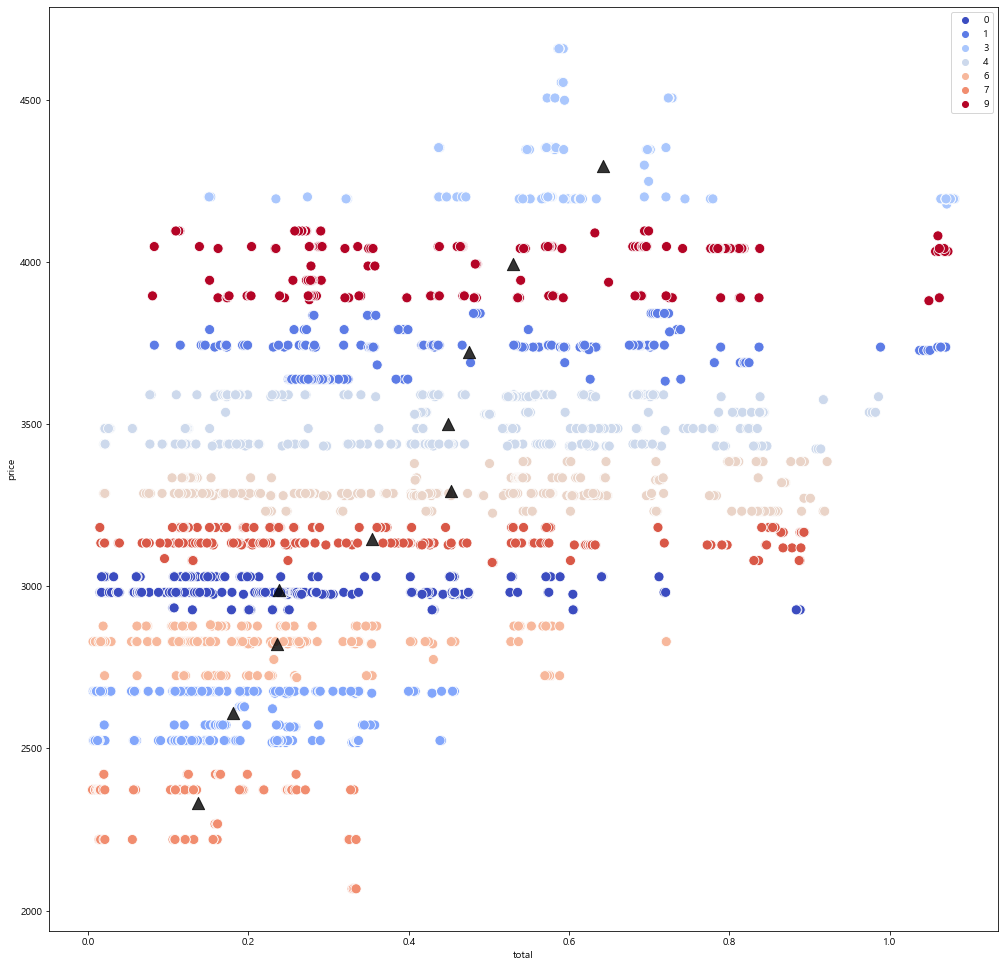

In [17]:
X= cluster_df
plt.figure(figsize=(17,17))
# plt.subplot(132)    # pig_ss
sns.scatterplot(x=X.iloc[:,-2], y=X.iloc[:,0], data=df_forkmeans, hue=cluster_model.labels_, palette='coolwarm', s= 100) #
plt.scatter(centers[:,-1], centers[:,0], c='black', alpha=0.8, s=150,  marker='^')
plt.show()

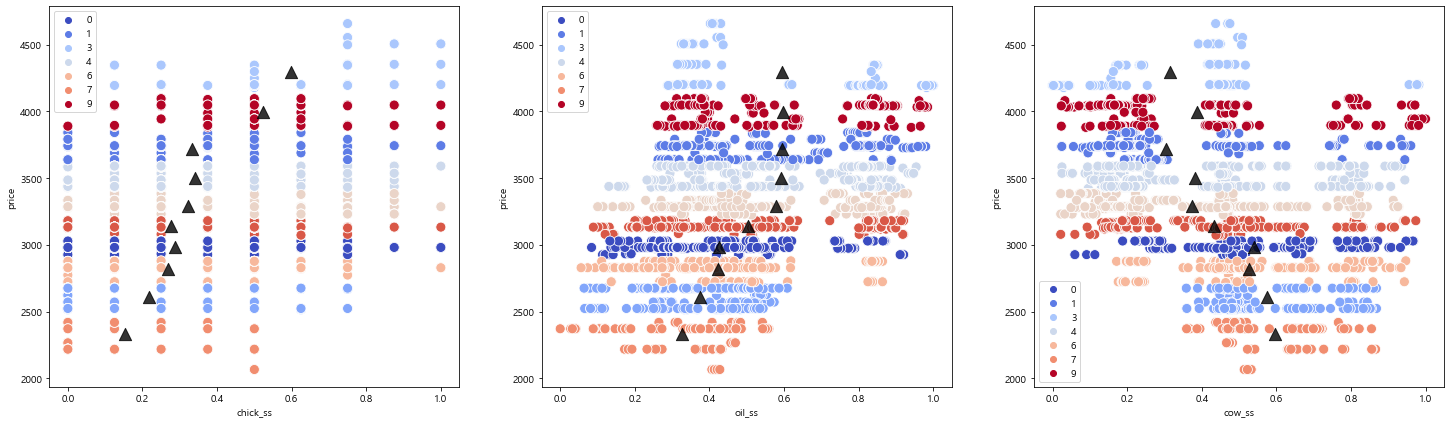

In [18]:

plt.figure(figsize=(25,7))
X= cluster_df

plt.subplot(131)    # chick_ss
sns.scatterplot(x=X.iloc[:,1], y=X.iloc[:,0], data=df_forkmeans, hue=cluster_model.labels_, palette='coolwarm', s= 100) #
plt.scatter(centers[:,1], centers[:,0], c='black', alpha=0.8, s=150,  marker='^')

plt.subplot(132)    # degree_ss
sns.scatterplot(x=X.iloc[:,2], y=X.iloc[:,0], data=df_forkmeans, hue=cluster_model.labels_, palette='coolwarm', s= 100) #
plt.scatter(centers[:,2], centers[:,0], c='black', alpha=0.8, s=150, marker='^')

plt.subplot(133)    # import_ss
sns.scatterplot(x=X.iloc[:,3], y=X.iloc[:,0], data=df_forkmeans, hue=cluster_model.labels_, palette='coolwarm', s= 100) #
plt.scatter(centers[:,3], centers[:,0], c='black', alpha=0.8, s=150,  marker='^')

plt.show()

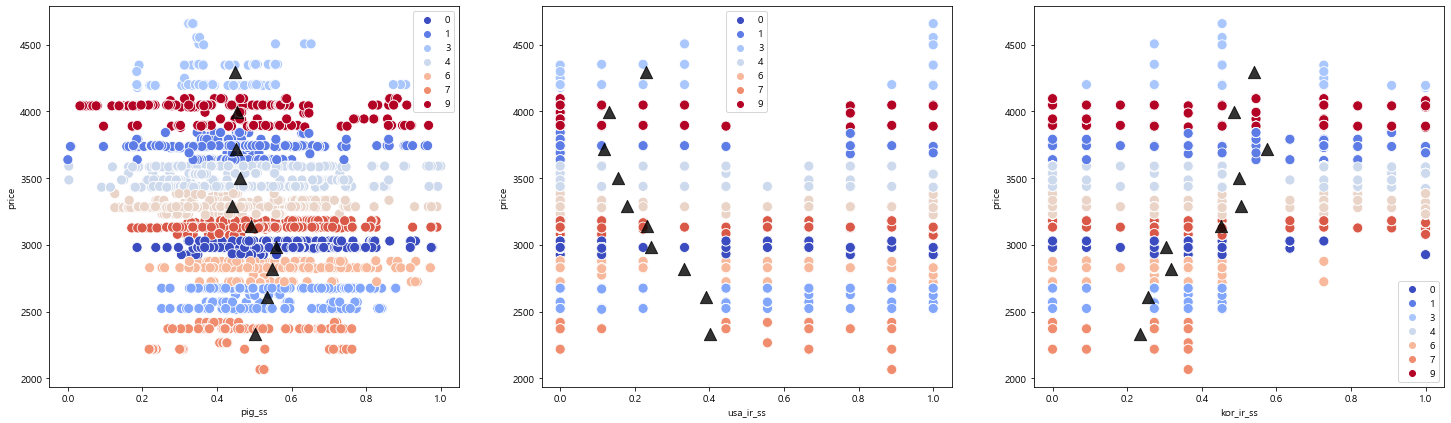

In [19]:

plt.figure(figsize=(25,7))
X= cluster_df

plt.subplot(131)    # feedprice_ss
sns.scatterplot(x=X.iloc[:,4], y=X.iloc[:,0], data=df_forkmeans, hue=cluster_model.labels_, palette='coolwarm', s= 100) #
plt.scatter(centers[:,4], centers[:,0], c='black', alpha=0.8, s=150,  marker='^')

plt.subplot(132)    # oil_ss
sns.scatterplot(x=X.iloc[:,5], y=X.iloc[:,0], data=df_forkmeans, hue=cluster_model.labels_, palette='coolwarm', s= 100) #
plt.scatter(centers[:,5], centers[:,0], c='black', alpha=0.8, s=150,  marker='^')

plt.subplot(133)    # butchery_ss
sns.scatterplot(x=X.iloc[:,6], y=X.iloc[:,0], data=df_forkmeans, hue=cluster_model.labels_, palette='coolwarm', s= 100) #
plt.scatter(centers[:,6], centers[:,0], c='black', alpha=0.8, s=150,  marker='^')

plt.show()

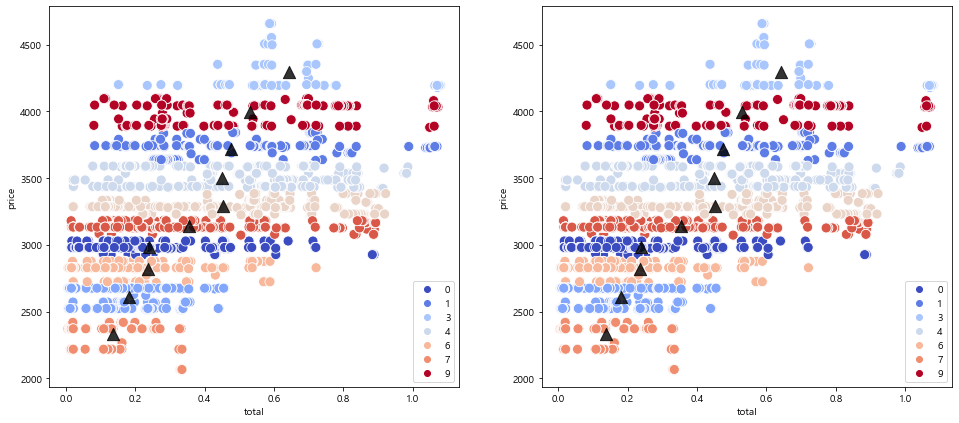

In [20]:
plt.figure(figsize=(25,7))
X= cluster_df

plt.subplot(131)    # cow_ss
sns.scatterplot(x=X.iloc[:,7], y=X.iloc[:,0], data=df_forkmeans, hue=cluster_model.labels_, palette='coolwarm', s= 100) #
plt.scatter(centers[:,7], centers[:,0], c='black', alpha=0.8, s=150,  marker='^')

plt.subplot(132)    # pig_ss
sns.scatterplot(x=X.iloc[:,-2], y=X.iloc[:,0], data=df_forkmeans, hue=cluster_model.labels_, palette='coolwarm', s= 100) #
plt.scatter(centers[:,-1], centers[:,0], c='black', alpha=0.8, s=150,  marker='^')

# plt.subplot(133)    # kor_ir_ss
# sns.scatterplot(x=X.iloc[:,9], y=X.iloc[:,0], data=df_forkmeans, hue=cluster_model.labels_, palette='coolwarm', s= 100) #
# plt.scatter(centers[:,9], centers[:,0], c='black', alpha=0.8, s=150,  marker='^')

plt.show()

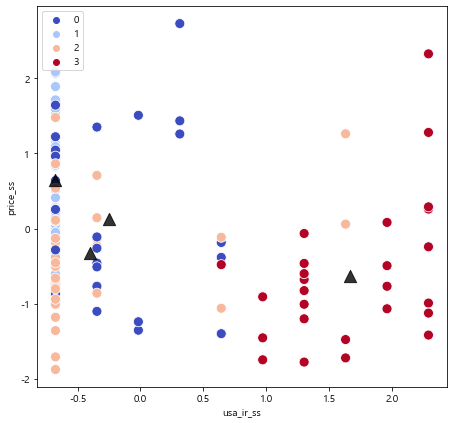

In [ ]:
plt.figure(figsize=(25,7))
X= cluster_df

plt.subplot(131)    # usa_ir_ss
sns.scatterplot(x=X.iloc[:,10], y=X.iloc[:,0], data=df_forkmeans, hue=cluster_model.labels_, palette='coolwarm', s= 100) #
plt.scatter(centers[:,10], centers[:,0], c='black', alpha=0.8, s=150,  marker='^')

plt.show()

# Kmeans clustering 거리 구하기

## 함수완성위한 과정 메모장

In [895]:
centers


array([[ 0.12260339,  0.93680371, -0.35454867, -0.86072036, -0.599337  ,
        -0.84707102, -0.33459446,  0.10579672,  0.06774536, -0.43792868,
        -0.24829765],
       [ 0.64076858, -0.31903831, -0.05423951, -0.08830439,  1.3100061 ,
         1.33492954, -0.81033671, -1.14413841, -0.82420475,  1.29383899,
        -0.67534522],
       [-0.3267815 , -0.43171582,  0.54064546,  0.50868249, -0.29890639,
        -0.61348227,  0.93706363,  0.90963921,  1.21296716, -0.96790048,
        -0.39904348],
       [-0.62491285, -0.01635118, -0.20132971,  0.40958656, -0.83507777,
        -0.23725368,  0.35219999,  0.38975599, -0.37537446, -0.18266208,
         1.66872355]])

공식
((cluster_df.chick_ss-x[i])**2) + ((cluster_df.price_ss-y[i])**2)**1/2
math.sqrt((cluster_df.chick_ss-x[i])**2) + ((cluster_df.price_ss-y[i])**2)

In [896]:
cluster_df

,price_ss,chick_ss,hot_day_ss,import_ss,feedprice_ss,oil_ss,butchery_ss,cow_ss,pig_ss,kor_ir_ss,usa_ir_ss,clust
0,-0.159385,-0.595025,-0.366806,-0.464388,1.669049,1.551781,-1.518443,-1.204931,-0.385416,2.064521,-0.675345,1
1,0.912513,0.300542,-0.366806,0.114858,1.573126,1.777018,-1.739662,-1.475541,-1.031083,2.064521,-0.675345,1
2,2.064919,0.721985,-0.366806,0.432926,1.525165,1.991432,-1.527532,-1.825197,-1.142948,2.064521,-0.675345,1
3,0.293756,-0.163046,-0.366806,1.543148,1.501185,1.825858,-1.365718,-1.621642,-1.296567,2.064521,-0.675345,1
4,-0.037474,-0.858427,-0.366806,2.020250,1.501185,1.433160,-0.437325,-1.517609,-0.973286,2.064521,-0.675345,1
...,...,...,...,...,...,...,...,...,...,...,...,...
115,0.537579,-0.268407,0.626053,-0.203210,0.685845,-0.005109,0.773465,1.476652,2.299818,-1.199544,-0.675345,2
116,-0.453813,0.237325,-0.366806,-0.354487,0.949631,0.148332,0.118381,1.735615,2.394352,-1.199544,-0.675345,2
117,1.476065,0.442779,-0.366806,0.936750,1.069534,0.527824,0.133306,2.265005,2.264294,-1.199544,-0.675345,2
118,-0.658531,-0.252602,-0.366806,0.083396,1.357301,0.431713,0.546410,2.020243,1.996361,-0.873137,-0.675345,2


In [898]:
for j,n in enumerate(cluster_df.columns):
    if j == 0:
        pass
    elif j == 11:
        pass
    else:
        x = centers[:,j]
        y = centers[:,0]
        print(n)
        n = cluster_df[n]
        print(n[0])
        break

    

chick_ss
-0.5950250314488696


In [899]:
# 일단 chick 기준으로 클러스터 좌표 추출
# x = centers[:,1]
# y = centers[:,0]
# for i, a in enumerate(x):
#     for j, b in enumerate(y):
#         if i == j:
#             print(i)
#             print(a,b)
#         else: pass

n_clusters = 4
# i = 0 1 2
for i in range(n_clusters):
    print(i)
    print(x[i], y[i])


0
0.9368037101788833 0.12260339159128994
1
-0.31903830937111444 0.6407685812072866
2
-0.431715815203496 -0.3267814956142725
3
-0.016351183313897788 -0.624912851245564


In [902]:
# 리스트 준비
list0 = []
list1 = []
list2 = []
list3 = []
cnt0 =0
cnt1 =0
cnt2 =0
cnt3 =0

# for 문 돌리기
for i in range(120):
    if cluster_df.clust[i] == 0:
        dist = math.sqrt((cluster_df.chick_ss[i]-x[0])**2 + (cluster_df.price_ss[i]-y[0])**2)
        list0.append(dist)
        cnt0 += 1
      
    elif cluster_df.clust[i] == 1:
        dist = math.sqrt((cluster_df.chick_ss[i]-x[1])**2 + (cluster_df.price_ss[i]-y[1])**2)
        list1.append(dist)
        cnt1 += 1
    
    elif cluster_df.clust[i] == 2:
        dist = math.sqrt((cluster_df.chick_ss[i]-x[1])**2 + (cluster_df.price_ss[i]-y[1])**2)
        list2.append(dist)
        cnt2 += 1

    else:
        dist = math.sqrt((cluster_df.chick_ss[i]-x[2])**2 + (cluster_df.price_ss[i]-y[2])**2)
        list3.append(dist)
        cnt3 += 1

In [904]:
# 리턴값 확인
print(cnt0)
print(sum(list0)/cnt0)
print(cnt1)
print(sum(list1)/cnt1)
print(cnt2)
print(sum(list2)/cnt2)
print(cnt3)
print(sum(list3)/cnt3)

27
1.3570575232548145
36
0.9101391779308103
31
1.2825020327627012
26
1.399879944779578


## 군집내 거리 함수

In [969]:
# 가격-각칼럼 산점도 상에서 군집중심점과 각 군집에 속한 점 간의 거리를 구하는 함수
def euclidean(cluster_df, centers, cluster_dist):
    

    for j,n in enumerate(cluster_df.columns):

        column_n = cluster_df[n]
        if j == 0:
            pass
        elif j >= 11:
            pass
        else:
            x = centers[:,j]
            y = centers[:,0]
        
            for i in range(120):
                if cluster_df.clust[i] == 0:
                    dist = math.sqrt((column_n[i]-x[0])**2 + (cluster_df.price_ss[i]-y[0])**2)
                    cluster_dist[f'{n}'][i] = dist
                
                elif cluster_df.clust[i] == 1:
                    dist = math.sqrt((column_n[i]-x[1])**2 + (cluster_df.price_ss[i]-y[1])**2)
                    cluster_dist[f'{n}'][i] = dist
                
                elif cluster_df.clust[i] == 2:
                    dist = math.sqrt((column_n[i]-x[1])**2 + (cluster_df.price_ss[i]-y[1])**2)
                    cluster_dist[f'{n}'][i] = dist
            
                else:
                    dist = math.sqrt((column_n[i]-x[2])**2 + (cluster_df.price_ss[i]-y[2])**2)
                    cluster_dist[f'{n}'][i] = dist

    
    return cluster_dist

In [957]:
print(cluster_df.price_ss[0])
print(cluster_df.price_ss[1])

-0.1593854739813105
0.9125129872375594


In [971]:
cluster_dist = cluster_df.copy()
euclidean(cluster_df, centers, cluster_dist)

C:\Users\admin\AppData\Local\Temp\ipykernel_22428\1577431183.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_dist[f'{n}'][i] = dist
C:\Users\admin\AppData\Local\Temp\ipykernel_22428\1577431183.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_dist[f'{n}'][i] = dist
C:\Users\admin\AppData\Local\Temp\ipykernel_22428\1577431183.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_dist[f'{n}'][i] = dist
C:\U

,price_ss,chick_ss,hot_day_ss,import_ss,feedprice_ss,oil_ss,butchery_ss,cow_ss,pig_ss,kor_ir_ss,usa_ir_ss,clust
0,-0.159385,0.846413,0.859037,0.884130,0.877017,0.829018,1.068486,0.802460,0.912569,1.110944,0.800154,1
1,0.912513,0.676553,0.414177,0.339293,0.378256,0.518929,0.968241,0.428571,0.341531,0.817188,0.271744,1
2,2.064919,1.764067,1.458047,1.516537,1.440312,1.568184,1.594545,1.578621,1.459384,1.619307,1.424150,1
3,0.293756,0.380462,0.467028,1.667949,0.396190,0.601189,0.654879,0.590277,0.586126,0.845203,0.347012,1
4,-0.037474,0.866576,0.746801,2.214953,0.704672,0.685319,0.774048,0.774270,0.694434,1.026628,0.678243,1
...,...,...,...,...,...,...,...,...,...,...,...,...
115,0.537579,0.114942,0.688074,0.154439,0.632634,1.344006,1.587160,2.622822,3.125727,2.495517,0.103190,2
116,-0.453813,1.227863,1.138335,1.126482,1.152379,1.614349,1.435487,3.080761,3.399590,2.723062,1.094581,2
117,1.476065,1.130524,0.891862,1.322292,0.869222,1.161525,1.260231,3.509982,3.199460,2.629577,0.835296,2
118,-0.658531,1.300997,1.336368,1.310596,1.300160,1.582397,1.878548,3.420744,3.105442,2.526651,1.299300,2


<function __main__.cluster_dist(cluster_df, centers, centers_df)>

In [951]:
centers

array([[ 0.12260339,  0.93680371, -0.35454867, -0.86072036, -0.599337  ,
        -0.84707102, -0.33459446,  0.10579672,  0.06774536, -0.43792868,
        -0.24829765],
       [ 0.64076858, -0.31903831, -0.05423951, -0.08830439,  1.3100061 ,
         1.33492954, -0.81033671, -1.14413841, -0.82420475,  1.29383899,
        -0.67534522],
       [-0.3267815 , -0.43171582,  0.54064546,  0.50868249, -0.29890639,
        -0.61348227,  0.93706363,  0.90963921,  1.21296716, -0.96790048,
        -0.39904348],
       [-0.62491285, -0.01635118, -0.20132971,  0.40958656, -0.83507777,
        -0.23725368,  0.35219999,  0.38975599, -0.37537446, -0.18266208,
         1.66872355]])

In [968]:
cluster_df

,price_ss,chick_ss,hot_day_ss,import_ss,feedprice_ss,oil_ss,butchery_ss,cow_ss,pig_ss,kor_ir_ss,usa_ir_ss,clust
0,-0.159385,-0.595025,-0.366806,-0.464388,1.669049,1.551781,-1.518443,-1.204931,-0.385416,2.064521,-0.675345,1
1,0.912513,0.300542,-0.366806,0.114858,1.573126,1.777018,-1.739662,-1.475541,-1.031083,2.064521,-0.675345,1
2,2.064919,0.721985,-0.366806,0.432926,1.525165,1.991432,-1.527532,-1.825197,-1.142948,2.064521,-0.675345,1
3,0.293756,-0.163046,-0.366806,1.543148,1.501185,1.825858,-1.365718,-1.621642,-1.296567,2.064521,-0.675345,1
4,-0.037474,-0.858427,-0.366806,2.020250,1.501185,1.433160,-0.437325,-1.517609,-0.973286,2.064521,-0.675345,1
...,...,...,...,...,...,...,...,...,...,...,...,...
115,0.537579,-0.268407,0.626053,-0.203210,0.685845,-0.005109,0.773465,1.476652,2.299818,-1.199544,-0.675345,2
116,-0.453813,0.237325,-0.366806,-0.354487,0.949631,0.148332,0.118381,1.735615,2.394352,-1.199544,-0.675345,2
117,1.476065,0.442779,-0.366806,0.936750,1.069534,0.527824,0.133306,2.265005,2.264294,-1.199544,-0.675345,2
118,-0.658531,-0.252602,-0.366806,0.083396,1.357301,0.431713,0.546410,2.020243,1.996361,-0.873137,-0.675345,2


## 군집간 거리함수( 중심점 기준 )

In [573]:
centers_df = pd.DataFrame(centers)
# centers_df['clst_dist'] = centers_df[0]
centers_df

,0,1,2,3,4,5,6
0,0.124691,0.909790,-0.617908,-0.514598,-0.663063,-0.638241,-0.254362
1,-0.656012,-0.629644,0.635218,0.557194,-0.565713,-0.539397,0.937228
2,0.593813,-0.261752,-0.051654,-0.074164,1.323223,1.268009,-0.768134


In [584]:
def cluster_dist(cluster_df, centers, centers_df):

    n_clusters = 3

    for j,n in enumerate(cluster_df.columns):   
        if j == 0:
            pass
        elif j >= 7:
            pass
        else:
            x = centers[:,j]
            y = centers[:,0]
            # print(n)
            # print(x[i], y[i])
            # n = cluster_df[n]
            # print(n[0])
            # centers_df[f'{n}_clst_dist'] = 0
            for i in range(n_clusters):

                if i != n_clusters:
                    clst_dist = math.sqrt((x[i]-x[i+1])**2 + (y[i]-y[i+1])**2)
                    centers_df[f'{n}_clst_dist'][i] = clst_dist
                elif i == n_clusters:
                    clst_dist = math.sqrt((x[i]-x[0])**2 + (y[i]-y[0])**2)
                    centers_df[f'{n}_clst_dist'][i] = clst_dist
                    

In [585]:
cluster_dist(cluster_df, centers, centers_df)

IndexError: index 3 is out of bounds for axis 0 with size 3

In [556]:
math.sqrt((x[0]-x[1])**2 + (y[0]-y[1])**2)
math.sqrt((x[1]-x[2])**2 + (y[1]-y[2])**2)
math.sqrt((x[2]-x[0])**2 + (y[2]-y[0])**2)

1.2619776437144823

In [542]:
centers

array([[ 0.12469062,  0.90979038, -0.61790753, -0.51459813, -0.66306319,
        -0.63824131, -0.2543618 ],
       [-0.65601204, -0.62964357,  0.63521815,  0.55719398, -0.56571343,
        -0.5393975 ,  0.93722763],
       [ 0.59381266, -0.26175223, -0.05165423, -0.07416374,  1.32322347,
         1.26800914, -0.76813391]])

# KNN으로 군집화

In [851]:
month_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120 entries, 0 to 119
Data columns (total 23 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   date          120 non-null    object 
 1   price         120 non-null    int64  
 2   chick         120 non-null    int64  
 3   hot_day       120 non-null    float64
 4   import        120 non-null    int64  
 5   feedprice     120 non-null    int64  
 6   oil           120 non-null    float64
 7   butchery      120 non-null    int64  
 8   cow           120 non-null    float64
 9   pig           120 non-null    float64
 10  kor_ir        120 non-null    float64
 11  usa_ir        120 non-null    float64
 12  price_ss      120 non-null    float64
 13  chick_ss      120 non-null    float64
 14  hot_day_ss    120 non-null    float64
 15  import_ss     120 non-null    float64
 16  feedprice_ss  120 non-null    float64
 17  oil_ss        120 non-null    float64
 18  butchery_ss   120 non-null    

In [842]:
# 일단 가격-수입량으로 1대1 knn을 구성해보자
month_df.columns

Index(['date', 'price', 'chick', 'hot_day', 'import', 'feedprice', 'oil',
       'butchery', 'cow', 'pig', 'kor_ir', 'usa_ir', 'price_ss', 'chick_ss',
       'hot_day_ss', 'import_ss', 'feedprice_ss', 'oil_ss', 'butchery_ss',
       'cow_ss', 'pig_ss', 'kor_ir_ss', 'usa_ir_ss'],
      dtype='object')

In [843]:
# 독립변수
data_df = month_df.drop(columns=['date', 'price', 'chick', 'hot_day', 'import', 'feedprice', 'oil',
                                 'butchery', 'cow', 'pig', 'kor_ir', 'usa_ir', 'price_ss'])
       
# 종속변수
target_df = month_df.drop(columns=['date', 'price', 'chick', 'hot_day', 'import', 'feedprice', 'oil',
       'butchery', 'cow', 'pig', 'kor_ir', 'usa_ir', 'chick_ss',
       'hot_day_ss', 'import_ss', 'feedprice_ss', 'oil_ss', 'butchery_ss',
       'cow_ss', 'pig_ss', 'kor_ir_ss', 'usa_ir_ss'])

In [844]:
knn = KNeighborsClassifier(n_neighbors=3)

In [845]:
X_train, X_test, Y_train, Y_test = train_test_split(data_df, target_df, test_size=0.2)

In [846]:
X_train.head()

,chick_ss,hot_day_ss,import_ss,feedprice_ss,oil_ss,butchery_ss,cow_ss,pig_ss,kor_ir_ss,usa_ir_ss
71,-0.837355,-0.366806,-0.482921,-1.064738,-0.335760,0.105155,0.340197,-0.014034,-0.220324,0.971838
86,0.953779,-0.366806,0.701431,-0.633087,-0.219267,0.196110,0.039188,-0.937103,0.106082,2.289585
53,0.047676,-0.366806,0.295441,-0.824932,-0.865057,0.783883,-0.090210,0.843292,-0.546731,-0.345909
93,0.405902,-0.366806,1.520306,-0.896874,-0.480471,0.486192,0.819153,-0.177967,-0.546731,1.301275
64,2.618479,-0.366806,-1.378511,-0.848913,-0.792451,-0.150199,-0.019190,0.834129,-0.546731,0.312965


In [847]:
Y_train.head()

,price_ss
71,-1.452104
86,0.289156
53,0.144242
93,-0.598726
64,2.725079


In [848]:
knn.fit(X_train, Y_train)

c:\Users\admin\anaconda3\envs\py3_10_4\lib\site-packages\sklearn\neighbors\_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


ValueError: Unknown label type: 'continuous'

In [852]:
y_pred = knn.predict(X_test)

AttributeError: 'KNeighborsClassifier' object has no attribute 'n_samples_fit_'

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(Y_test, y_pred))
print(classification_report(Y_test, y_pred))
# print("prediction accuracy: {:.2f}".format(np.mean(y_pred == Y_test)))

# 221109 2차 데이터전처리
- 25도이상평균기온, 13도미만평균기온, hot_day, cold_day 전처리
    - 25도이상평균기온, 13도미만평균기온 : 값 - 기준치 로 변환
    - hot_day, cold_day
        - 1) NaN -> 0
        - 2) 원핫인코딩
    

In [357]:
month_df = pd.read_csv('./pre_data/월별_통합.csv', encoding='utf8')
month_df.columns

Index(['Unnamed: 0', 'date', '닭고기가격', '병아리(원/수)', '일별_평균기온', '일별_최저기온',
       '일별_최고기온', '13도미만_평균기온', '13도미만_최저기온', '13도미만_최고기온', '25도이상_평균기온',
       '25도이상_최저기온', '25도이상_최고기온', 'hot_day', 'cold_day', 'import amount',
       'feedprice', 'Dubai', 'Brent', 'WTI', 'oil_avg', 'count', '도축'],
      dtype='object')

In [358]:
# 살릴 칼럼 : 'date', '닭고기가격','병아리(원/수)', '13도미만_평균기온', '25도이상_평균기온', 'hot_day', 'cold_day', 'import amount','feedprice', 'oil_avg', '도축'
month_df.drop(columns=['Unnamed: 0', '일별_평균기온', '일별_최저기온',
       '일별_최고기온', '13도미만_최저기온', '13도미만_최고기온', '25도이상_최저기온', '25도이상_최고기온', 
        'Dubai', 'Brent', 'WTI', 'count'], inplace=True)
month_df

,date,닭고기가격,병아리(원/수),13도미만_평균기온,25도이상_평균기온,hot_day,cold_day,import amount,feedprice,oil_avg,도축
0,2012-01-31,3202,250,-1.5,NaN,NaN,4.0,8754,533,107.066111,58873
1,2012-02-29,3668,420,-1.1,NaN,NaN,3.0,10098,529,112.537302,55879
2,2012-03-31,4169,500,5.4,NaN,NaN,NaN,10836,527,117.745606,58750
3,2012-04-30,3399,332,12.4,NaN,NaN,NaN,13412,526,113.723667,60940
4,2012-05-31,3255,200,NaN,NaN,NaN,NaN,14519,526,104.184710,73505
...,...,...,...,...,...,...,...,...,...,...,...
115,2021-08-31,3505,312,NaN,NaN,3.0,NaN,9360,492,69.247955,89892
116,2021-09-30,3074,408,NaN,NaN,NaN,NaN,9009,503,72.975152,81026
117,2021-10-31,3913,447,NaN,NaN,NaN,NaN,12005,508,82.193333,81228
118,2021-11-30,2985,315,8.3,NaN,NaN,NaN,10025,520,79.858712,86819


In [359]:
month_df.columns = ['date','price','chick','dgr13','dgr25','hot','cold','import','feed','oil','butchery']

In [360]:
month_df

,date,price,chick,dgr13,dgr25,hot,cold,import,feed,oil,butchery
0,2012-01-31,3202,250,-1.5,NaN,NaN,4.0,8754,533,107.066111,58873
1,2012-02-29,3668,420,-1.1,NaN,NaN,3.0,10098,529,112.537302,55879
2,2012-03-31,4169,500,5.4,NaN,NaN,NaN,10836,527,117.745606,58750
3,2012-04-30,3399,332,12.4,NaN,NaN,NaN,13412,526,113.723667,60940
4,2012-05-31,3255,200,NaN,NaN,NaN,NaN,14519,526,104.184710,73505
...,...,...,...,...,...,...,...,...,...,...,...
115,2021-08-31,3505,312,NaN,NaN,3.0,NaN,9360,492,69.247955,89892
116,2021-09-30,3074,408,NaN,NaN,NaN,NaN,9009,503,72.975152,81026
117,2021-10-31,3913,447,NaN,NaN,NaN,NaN,12005,508,82.193333,81228
118,2021-11-30,2985,315,8.3,NaN,NaN,NaN,10025,520,79.858712,86819


In [361]:
# 기준값 감산, hot, cold 칼럼 그대로, 결측치 처리
month_df['dgr13'] = month_df['dgr13']-13
month_df['dgr25'] = month_df['dgr25']-25
month_df.fillna(0, inplace=True)
month_df

,date,price,chick,dgr13,dgr25,hot,cold,import,feed,oil,butchery
0,2012-01-31,3202,250,-14.5,0.0,0.0,4.0,8754,533,107.066111,58873
1,2012-02-29,3668,420,-14.1,0.0,0.0,3.0,10098,529,112.537302,55879
2,2012-03-31,4169,500,-7.6,0.0,0.0,0.0,10836,527,117.745606,58750
3,2012-04-30,3399,332,-0.6,0.0,0.0,0.0,13412,526,113.723667,60940
4,2012-05-31,3255,200,0.0,0.0,0.0,0.0,14519,526,104.184710,73505
...,...,...,...,...,...,...,...,...,...,...,...
115,2021-08-31,3505,312,0.0,0.0,3.0,0.0,9360,492,69.247955,89892
116,2021-09-30,3074,408,0.0,0.0,0.0,0.0,9009,503,72.975152,81026
117,2021-10-31,3913,447,0.0,0.0,0.0,0.0,12005,508,82.193333,81228
118,2021-11-30,2985,315,-4.7,0.0,0.0,0.0,10025,520,79.858712,86819


In [362]:
# month_df['dgr25'].unique()
month_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120 entries, 0 to 119
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   date      120 non-null    object 
 1   price     120 non-null    int64  
 2   chick     120 non-null    int64  
 3   dgr13     120 non-null    float64
 4   dgr25     120 non-null    float64
 5   hot       120 non-null    float64
 6   cold      120 non-null    float64
 7   import    120 non-null    int64  
 8   feed      120 non-null    int64  
 9   oil       120 non-null    float64
 10  butchery  120 non-null    int64  
dtypes: float64(5), int64(5), object(1)
memory usage: 10.4+ KB


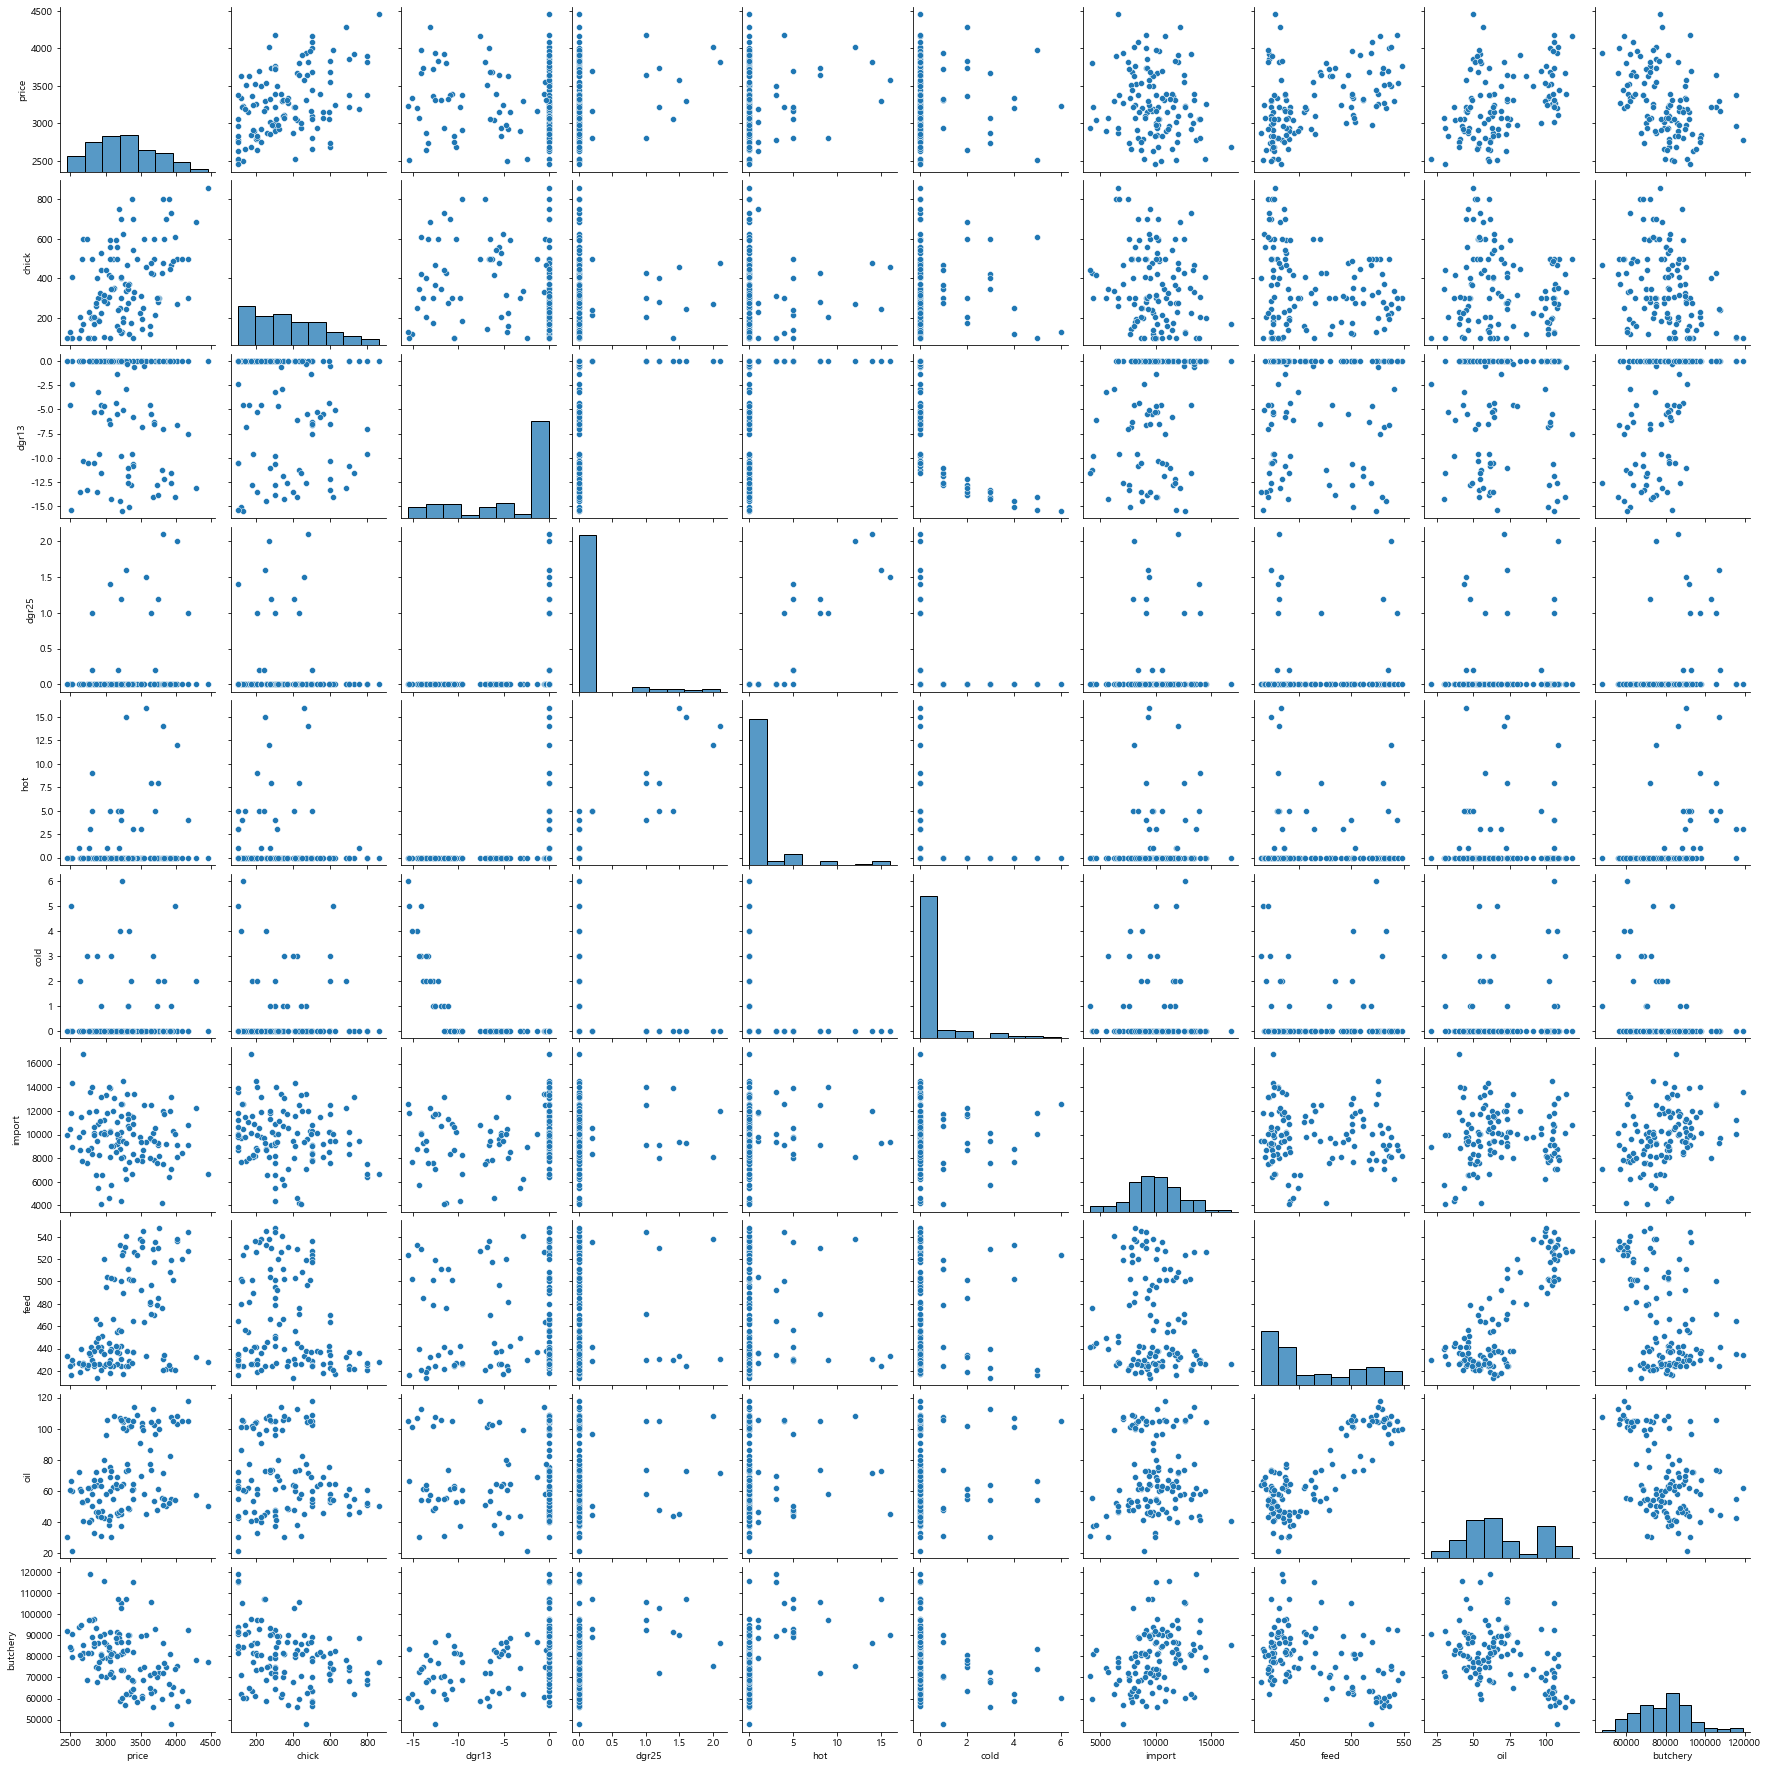

In [363]:
sns.pairplot(month_df, diag_kind='hist')
plt.show()

In [375]:
df_corr = df_heatmap.corr()

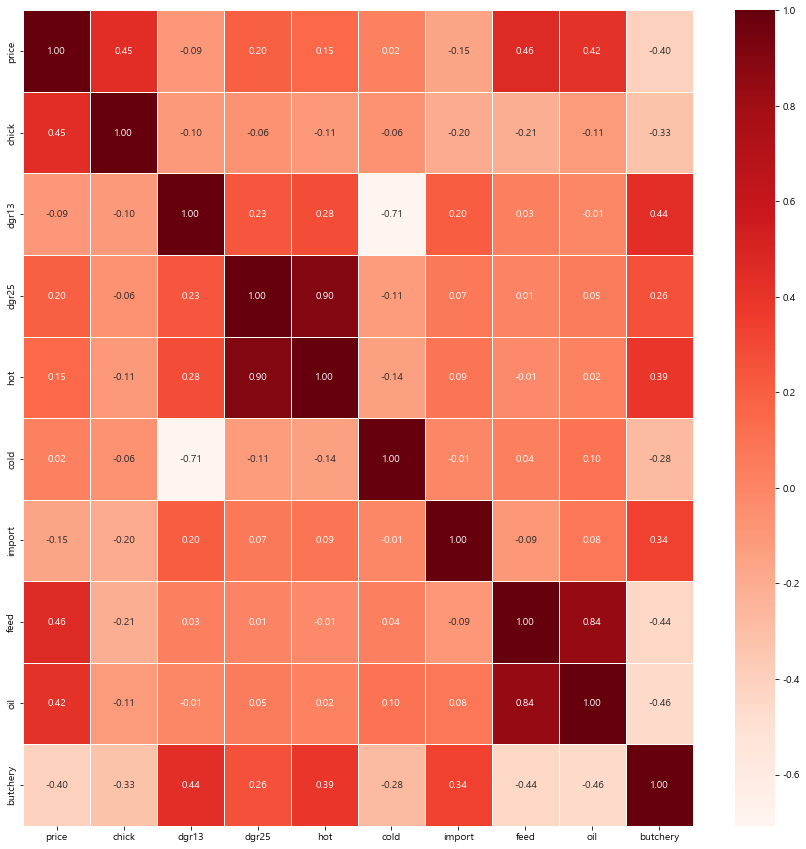

In [377]:
# fig, ax = plt.subplots(figsize=(15,15))
plt.figure(figsize=(15,15))
sns.heatmap(data=df_corr,annot=True, fmt='.2f', linewidths=.5, cmap='Reds')

plt.show()

# 221110 기준금리 전처리

## 미금리 만지기

In [648]:
air_df = pd.read_csv('./data/미국기준금리.csv', encoding='cp949')
air_df = air_df.loc[::-1]
air_df.reset_index(drop=True, inplace=True)
# air_df.clolumns = ['date', 'interest_a']
air_df

Index(['date', '미국기준금리'], dtype='object')

In [653]:
# air_df['date'].str.strip('년')
air_df['date'] = air_df['date'].str.replace('년 ','-') 
air_df['date'] = air_df['date'].str.replace('월 ','-') 
air_df['date'] = air_df['date'].str.replace('일','') 
air_df['date'] = air_df['date'].str.replace('.','-')
air_df['date'] = air_df['date'].str.rstrip('-')


air_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87 entries, 0 to 86
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   date    87 non-null     object
 1   미국기준금리  87 non-null     object
dtypes: object(2)
memory usage: 1.5+ KB


C:\Users\admin\AppData\Local\Temp\ipykernel_22428\2894125743.py:5: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  air_df['date'] = air_df['date'].str.replace('.','-')


In [674]:
# 데이터 형 변환
air_df['date'] = pd.to_datetime(air_df['date'])

# 각 날짜를 월말로 바꿈
air_df['date'] = air_df['date'] + pd.offsets.MonthEnd(0) 
air_df

# 2022년 데이터 제거
drop_2022 = air_df[air_df['date'] >= '2022-01-01' ].index
drop_2022 = air_df.drop(drop_2022)
drop_2022

,date,미국기준금리
0,2012-01-31,0.25%
1,2012-03-31,0.25%
2,2012-04-30,0.25%
3,2012-06-30,0.25%
4,2012-08-31,0.25%
...,...,...
76,2021-06-30,0.25%
77,2021-07-31,0.25%
78,2021-09-30,0.25%
79,2021-11-30,0.25%


In [686]:
drop_2022 = drop_2022.drop(index=65)
drop_2022.reset_index(drop=True, inplace=True)
drop_2022.tail(20)

,date,미국기준금리
60,2019-08-31,2.25
61,2019-09-30,2.00
62,2019-10-31,1.75
63,2019-12-31,1.75
64,2020-01-31,1.75
65,2020-03-31,0.25
66,2020-04-30,0.25
67,2020-06-30,0.25
68,2020-07-31,0.25
69,2020-09-30,0.25


In [687]:
drop_2022['미국기준금리'] = drop_2022['미국기준금리'].str.replace('%', '')
drop_2022['미국기준금리'] = pd.to_numeric(drop_2022['미국기준금리'])

AttributeError: Can only use .str accessor with string values!

In [688]:
month_df['date'] = pd.to_datetime(month_df['date'])
month_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120 entries, 0 to 119
Data columns (total 19 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date          120 non-null    datetime64[ns]
 1   price         120 non-null    int64         
 2   chick         120 non-null    int64         
 3   degree        120 non-null    float64       
 4   hot_day       22 non-null     float64       
 5   cold_day      20 non-null     float64       
 6   import        120 non-null    int64         
 7   feedprice     120 non-null    int64         
 8   oil           120 non-null    float64       
 9   butchery      120 non-null    int64         
 10  price_ss      120 non-null    float64       
 11  chick_ss      120 non-null    float64       
 12  degree_ss     120 non-null    float64       
 13  hot_day_ss    22 non-null     float64       
 14  cold_day_ss   20 non-null     float64       
 15  import_ss     120 non-null    float64   

In [691]:
totaldf = pd.merge(month_df, drop_2022,how='outer', on='date')
totaldf = totaldf.fillna(method='ffill')
totaldf

,date,price,chick,degree,hot_day,cold_day,import,feedprice,oil,butchery,price_ss,chick_ss,degree_ss,hot_day_ss,cold_day_ss,import_ss,feedprice_ss,oil_ss,butchery_ss,미국기준금리
0,2012-01-31,3202,250,-1.5,NaN,4.0,8754,533,107.066111,58873,-0.159385,-0.595025,-1.565130,NaN,0.935414,-0.464388,1.669049,1.551781,-1.518443,0.25
1,2012-02-29,3668,420,-1.1,NaN,3.0,10098,529,112.537302,55879,0.912513,0.300542,-1.521692,NaN,0.267261,0.114858,1.573126,1.777018,-1.739662,0.25
2,2012-03-31,4169,500,5.4,NaN,3.0,10836,527,117.745606,58750,2.064919,0.721985,-0.815823,NaN,0.267261,0.432926,1.525165,1.991432,-1.527532,0.25
3,2012-04-30,3399,332,12.4,NaN,3.0,13412,526,113.723667,60940,0.293756,-0.163046,-0.055655,NaN,0.267261,1.543148,1.501185,1.825858,-1.365718,0.25
4,2012-05-31,3255,200,18.1,NaN,3.0,14519,526,104.184710,73505,-0.037474,-0.858427,0.563338,NaN,0.267261,2.020250,1.501185,1.433160,-0.437325,0.25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,2021-08-31,3505,312,24.8,3.0,5.0,9360,492,69.247955,89892,0.537579,-0.268407,1.290927,-0.681795,1.603567,-0.203210,0.685845,-0.005109,0.773465,0.25
116,2021-09-30,3074,408,21.3,3.0,5.0,9009,503,72.975152,81026,-0.453813,0.237325,0.910843,-0.681795,1.603567,-0.354487,0.949631,0.148332,0.118381,0.25
117,2021-10-31,3913,447,15.1,3.0,5.0,12005,508,82.193333,81228,1.476065,0.442779,0.237552,-0.681795,1.603567,0.936750,1.069534,0.527824,0.133306,0.25
118,2021-11-30,2985,315,8.3,3.0,5.0,10025,520,79.858712,86819,-0.658531,-0.252602,-0.500896,-0.681795,1.603567,0.083396,1.357301,0.431713,0.546410,0.25


In [699]:
air_modified = totaldf.copy()
air_modified.drop(columns=['price','chick','degree','hot_day','cold_day','import','feedprice','oil','butchery','price_ss','chick_ss','degree_ss','hot_day_ss','cold_day_ss','import_ss','feedprice_ss','oil_ss','butchery_ss'], inplace=True)
air_modified

,date,미국기준금리
0,2012-01-31,0.25
1,2012-02-29,0.25
2,2012-03-31,0.25
3,2012-04-30,0.25
4,2012-05-31,0.25
...,...,...
115,2021-08-31,0.25
116,2021-09-30,0.25
117,2021-10-31,0.25
118,2021-11-30,0.25


In [768]:
air_modified.to_csv('./pre_data/미금리전처리.csv', sep=',', encoding='cp949', index=False)

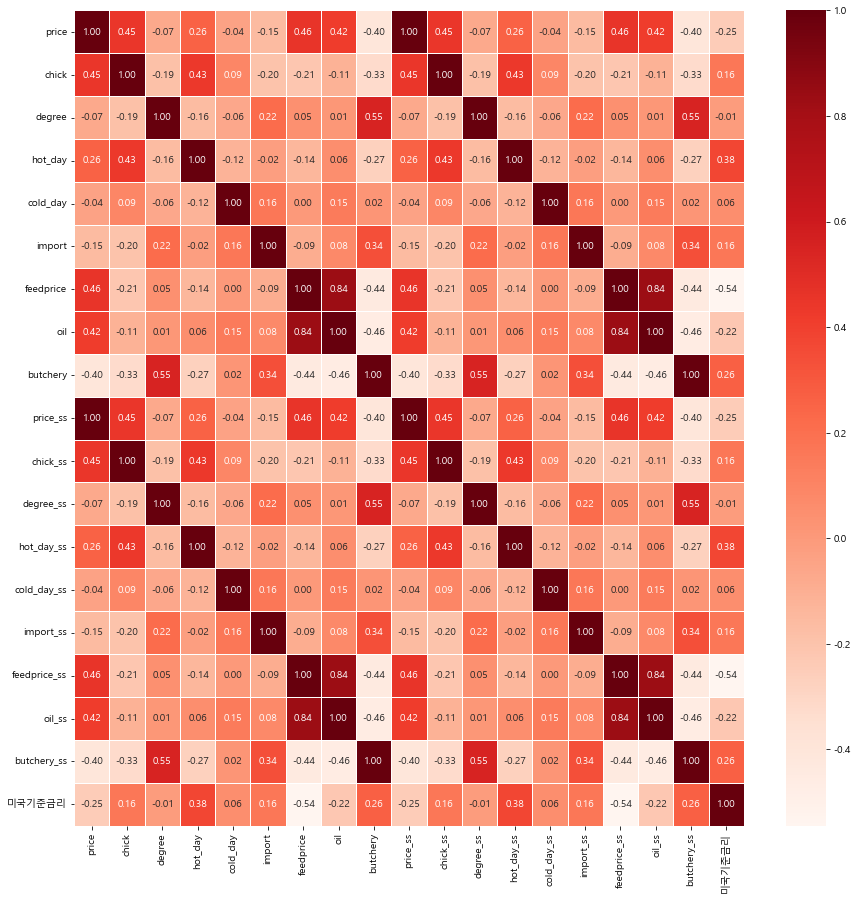

In [693]:
totalcorr = totaldf.corr()

plt.figure(figsize=(15,15))
sns.heatmap(data=totalcorr,annot=True, fmt='.2f', linewidths=.5, cmap='Reds')

plt.show()

# 221110 일별 군집용 데이터 정리

In [982]:
daily_df = pd.read_csv('./pre_data/일별_통합.csv', encoding='utf8')
daily_df.drop(columns=['Unnamed: 0'], inplace=True)
daily_df = daily_df.loc[::-1].reset_index(drop=True)
daily_df.co

,date,price,병아리(원/수),Dubai,Brent,WTI,oil_avg,일별_평균기온,일별_최저기온,일별_최고기온,13도미만_평균기온,13도미만_최저기온,13도미만_최고기온,25도이상_평균기온,25도이상_최저기온,25도이상_최고기온
0,2012-01-02,3118,300.0,NaN,NaN,NaN,NaN,-2.8,-7.5,2.6,-2.8,-7.5,2.6,NaN,NaN,NaN
1,2012-01-03,3118,300.0,105.91,112.13,102.96,107.000000,-1.9,-5.8,2.8,-1.9,-5.8,2.8,NaN,NaN,NaN
2,2012-01-04,3118,300.0,108.49,113.70,103.22,108.470000,-4.0,-6.6,-1.0,-4.0,-6.6,-1.0,NaN,NaN,NaN
3,2012-01-05,3118,200.0,110.23,112.74,101.81,108.260000,-4.1,-8.7,1.5,-4.1,-8.7,1.5,NaN,NaN,NaN
4,2012-01-06,3166,200.0,109.92,113.06,101.56,108.180000,-2.6,-7.8,3.7,-2.6,-7.8,3.7,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2991,2021-12-27,3743,400.0,75.42,78.60,75.57,76.530000,-4.6,-11.2,0.5,-4.6,-11.2,0.5,NaN,NaN,NaN
2992,2021-12-28,3895,400.0,76.47,78.94,75.98,77.130000,0.0,-5.2,4.9,0.0,-5.2,4.9,NaN,NaN,NaN
2993,2021-12-29,3895,400.0,76.91,79.23,76.56,77.566667,2.5,-2.5,7.5,2.5,-2.5,7.5,NaN,NaN,NaN
2994,2021-12-30,4047,400.0,77.24,79.32,76.99,77.850000,-0.7,-3.3,2.7,-0.7,-3.3,2.7,NaN,NaN,NaN


# 소비자물가지수 만지기

In [191]:
cpi = pd.read_csv('./data/소비자_물가지수_2012_2022.csv')
cpi.drop(columns=['Unnamed: 0'], inplace=True)
cpi['date'] = cpi['date'].astype('str')

# cpi['year'] = cpi['date'].str[:4]
# cpi['month'] = cpi['date'].str[4:7]
cpi

,date,value,agg
0,201201,3.8,100.000000
1,201202,0.1,100.000000
2,201203,2.9,100.000000
3,201204,4.0,100.000000
4,201205,7.0,100.000000
...,...,...,...
115,202108,5.6,128.954004
116,202109,3.1,124.989652
117,202110,0.5,125.276336
118,202111,7.6,131.414445


In [147]:
# agg 먼저 만들기


daily_df['date'].str[:4] + daily_df['date'].str[5:7]


1       201201
2       201201
3       201201
4       201201
5       201201
         ...  
2991    202112
2992    202112
2993    202112
2994    202112
2995    202112
Name: date, Length: 2995, dtype: object

In [190]:
for i, row in daily_df.iterrows():
     if row['date'] == cpi.iterrows():

     # print(row['date'])
     # if row['value'] == cpi['date']:
          break    

no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
n

# LSTM 맛만보자

In [250]:
# daily_df
lstm_y = daily_df.drop(columns=['chick','oil','cow','pig','usa_ir','kor_ir'])
lstm_x = daily_df.drop(columns=['price'])
lstm_total = daily_df.copy()

In [235]:
daily_df

,date,price,chick,oil,cow,pig,usa_ir,kor_ir
1,2012-01-03,3118.0,300.0,105.91,61030.0,20330.0,0.75,3.25
2,2012-01-04,3118.0,300.0,108.49,61700.0,20300.0,0.75,3.25
3,2012-01-05,3118.0,200.0,110.23,58870.0,19830.0,0.75,3.25
4,2012-01-06,3166.0,200.0,109.92,58380.0,19570.0,0.75,3.25
5,2012-01-07,3319.0,200.0,109.92,58380.0,19570.0,0.75,3.25
...,...,...,...,...,...,...,...,...
2991,2021-12-27,3743.0,400.0,75.42,109225.0,26993.0,0.25,1.00
2992,2021-12-28,3895.0,400.0,76.47,110865.0,26936.0,0.25,1.00
2993,2021-12-29,3895.0,400.0,76.91,112019.0,26891.0,0.25,1.00
2994,2021-12-30,4047.0,400.0,77.24,111396.0,25411.0,0.25,1.00


In [236]:
# 칼럼별 정규화 함수
def scaler_self(df):
    '''
        df : 정규화시킬 데이터프레임. 데이터프레임 내 date 칼럼을 제외하고 모두 float, int타입 일 것
    '''
    df_pure = df.drop(columns=['date'])
    col_list = df_pure.columns

    for i,x in enumerate(col_list):
        list=[]
        scale_df = df[[col_list[i]]].to_numpy()

        ss = StandardScaler()
        ss.fit(scale_df)

        Scale=ss.transform(scale_df)
        
        for j in Scale:
            list.append(j[0])

        df[f'{x}'] = list

In [237]:
ss = MinMaxScaler()

In [238]:
scaler_self(lstm_y)
scaler_self(lstm_x)
scaler_self(lstm_total)

In [252]:
lstm_y

,date,price
1,2012-01-03,3118.0
2,2012-01-04,3118.0
3,2012-01-05,3118.0
4,2012-01-06,3166.0
5,2012-01-07,3319.0
...,...,...
2991,2021-12-27,3743.0
2992,2021-12-28,3895.0
2993,2021-12-29,3895.0
2994,2021-12-30,4047.0


In [251]:
lstm_x

,date,chick,oil,cow,pig,usa_ir,kor_ir
1,2012-01-03,300.0,105.91,61030.0,20330.0,0.75,3.25
2,2012-01-04,300.0,108.49,61700.0,20300.0,0.75,3.25
3,2012-01-05,200.0,110.23,58870.0,19830.0,0.75,3.25
4,2012-01-06,200.0,109.92,58380.0,19570.0,0.75,3.25
5,2012-01-07,200.0,109.92,58380.0,19570.0,0.75,3.25
...,...,...,...,...,...,...,...
2991,2021-12-27,400.0,75.42,109225.0,26993.0,0.25,1.00
2992,2021-12-28,400.0,76.47,110865.0,26936.0,0.25,1.00
2993,2021-12-29,400.0,76.91,112019.0,26891.0,0.25,1.00
2994,2021-12-30,400.0,77.24,111396.0,25411.0,0.25,1.00


In [241]:
lstm_total

,date,price,chick,oil,cow,pig,usa_ir,kor_ir
1,2012-01-03,-0.310996,-0.300259,1.411054,-1.149571,0.245612,-0.015069,2.046040
2,2012-01-04,-0.310996,-0.300259,1.512673,-1.103425,0.235402,-0.015069,2.046040
3,2012-01-05,-0.310996,-0.793013,1.581206,-1.298342,0.075443,-0.015069,2.046040
4,2012-01-06,-0.215296,-0.793013,1.568996,-1.332091,-0.013045,-0.015069,2.046040
5,2012-01-07,0.089751,-0.793013,1.568996,-1.332091,-0.013045,-0.015069,2.046040
...,...,...,...,...,...,...,...,...
2991,2021-12-27,0.935108,0.192495,0.210143,2.169876,2.513287,-0.678778,-0.872775
2992,2021-12-28,1.238161,0.192495,0.251499,2.282831,2.493888,-0.678778,-0.872775
2993,2021-12-29,1.238161,0.192495,0.268830,2.362313,2.478573,-0.678778,-0.872775
2994,2021-12-30,1.541214,0.192495,0.281827,2.319404,1.974872,-0.678778,-0.872775


In [242]:
TEST_SIZE = 60
WINDOW_SIZE = 20

train = lstm_total[:-TEST_SIZE]
test = lstm_total[-TEST_SIZE:]

In [243]:
def make_dataset(data, label, window_size=20):
    feature_list = []
    label_list = []
    for i in range(len(data) - window_size):
        feature_list.append(np.array(data.iloc[i:i+window_size]))
        label_list.append(np.array(label.iloc[i+window_size]))
    return np.array(feature_list), np.array(label_list)

In [244]:
feature_cols = ['date', 'oil', 'cow', 'pig', 'usa_ir','kor_ir']
label_cols = ['price']

train_feature = train[feature_cols]
train_label = train[label_cols]

train_feature, train_label = make_dataset(train_feature, train_label, 20)

x_train, x_test, y_train, y_test = train_test_split(train_feature, train_label, test_size= .80)
x_train.shape, x_test.shape


((583, 20, 6), (2332, 20, 6))

In [245]:
test_feature = test[feature_cols]
test_label = test[label_cols]

test_feature.shape, test_label.shape

((60, 6), (60, 1))

In [246]:
test_feature, test_label = make_dataset(test_feature, test_label, 20)
test_feature.shape, test_label.shape

((40, 20, 6), (40, 1))

# dkdkdkdk

In [256]:
# !pip install pmdarima
# !pip install pandas_datareader

In [257]:
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima.arima import auto_arima

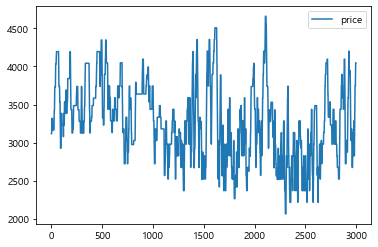

In [253]:
fig = lstm_y.plot()

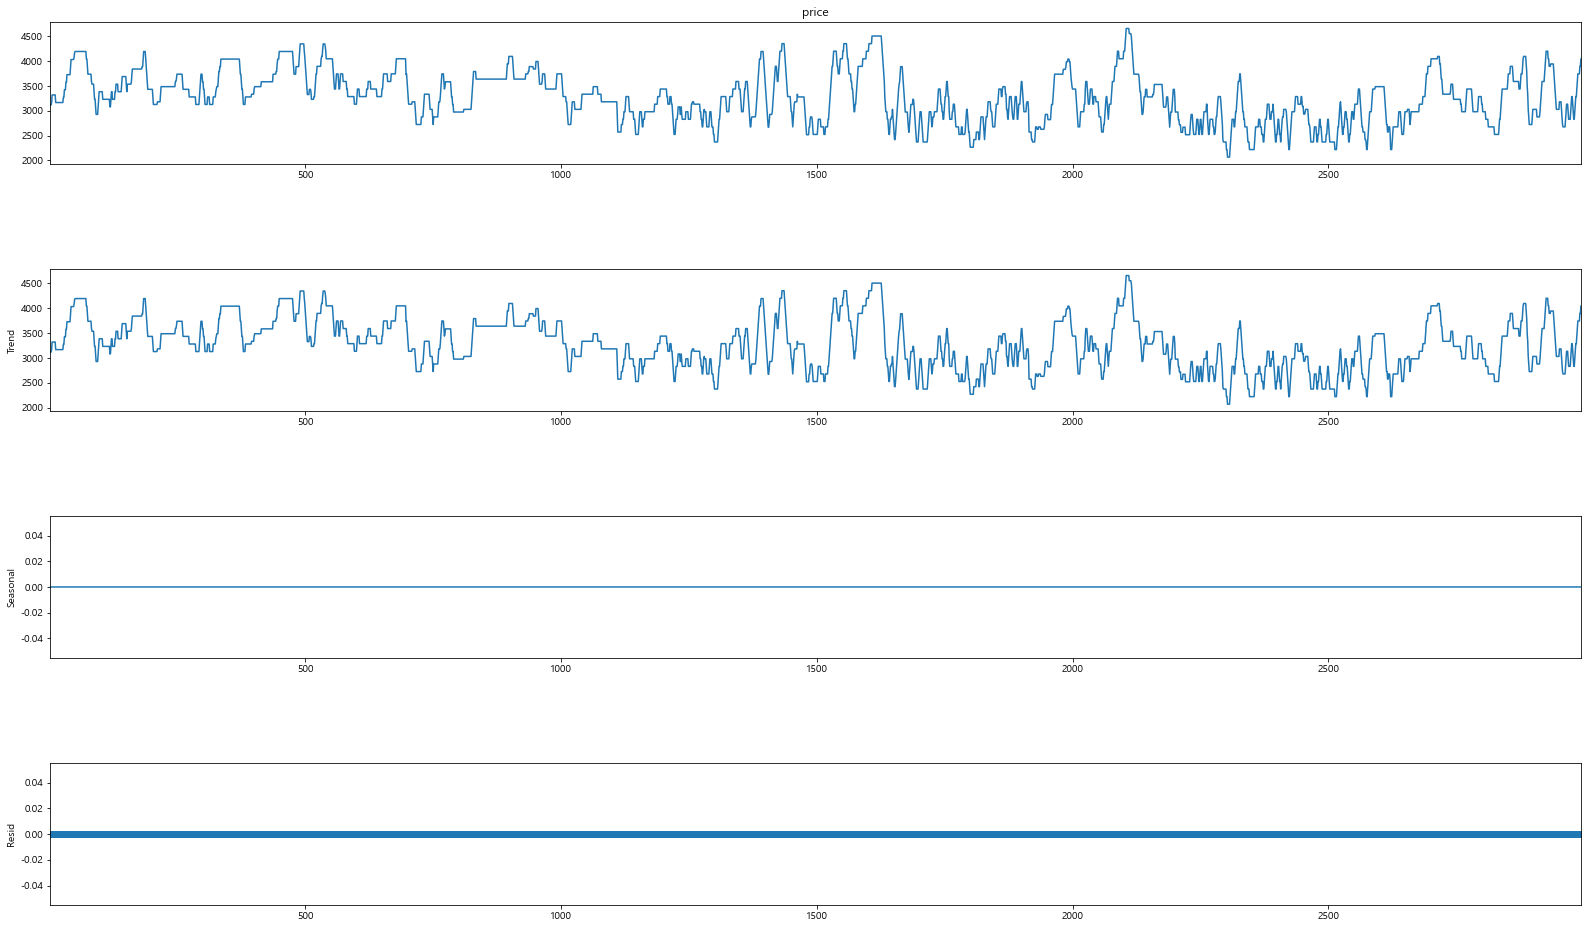

In [260]:
decomposition = sm.tsa.seasonal_decompose(lstm_y['price'], model='addictive', period=1)
fig = decomposition.plot()
fig.set_size_inches(25,15)
plt.show()

In [262]:
train_data, test_data = train_test_split(lstm_y, test_size=0.2, shuffle=False)

ValueError: could not convert string to float: '2012-01-03'

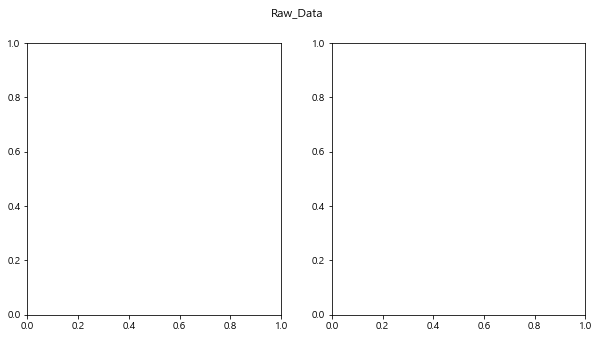

In [265]:
fig, ax = plt.subplots(1,2,figsize=(10,5))
fig.suptitle('Raw_Data')
sm.graphics.tsa.plot_acf(train_data.values.squeeze(), lags=30, ax=ax[0])
sm.graphics.tsa.plot_pacf(train_data.values.squeeze(), lags=30, ax=ax[1]);